# Exploring The Wavelet Feature Scoring Methods

## Load Libraries

In [12]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import umap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import os
from rich.console import Console

console = Console()

### Select Initial Dataset

Search for a volume that has SWT and not skipped features.

In [15]:
final_directory = None
for directory, subdir, files in os.walk("../datasets/annotated_ht_ef_datasets"):
	for d in subdir:
		if 'SWT' in d:
			for _, _, f in os.walk(os.path.join(directory, d)):
				for file in f:
					if file.endswith('.csv') and ('skipped' not in file):
						final_directory = directory
						break
console.print(f"Final directory: {final_directory}", style="bright_cyan")

Final directory: ../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032893

We will have multiple comparisons because we have both full and subset datasets, and we want to ensure that our rankings are consistent across these datasets.

- Within a wavelet family we have between signal types, along with full vs subset datasets
- Then across wavelet families we also have full vs subset datasets

In practice, this will look like:

1. **Full vs. Subset** Within Wavelet Family & Signal Type
2. **Full vs. Subset** Within Just Wavelet Family
3. **Full vs. Subset** Across Wavelet Families


## Full vs. Subset Within Wavelet Family & Signal Type

## Load Config and Datasets

In [2]:
data = json.load(open('../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/mdp_39015061285097/DWT_results/raw_results/mdp_39015061285097_ranking_config.json'))
ranking_config = pd.json_normalize(data)
exploded_metrics = pd.json_normalize(ranking_config['metrics'].explode())
subset_ranking_config = ranking_config.drop(columns=['metrics'])
repeated_subset_ranking_config = pd.concat([subset_ranking_config] * len(exploded_metrics), ignore_index=True)
metrics_config_df = pd.concat([repeated_subset_ranking_config, exploded_metrics], axis=1)

In [3]:
full_raw_df = pd.read_csv("../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/mdp_39015061285097/DWT_results/raw_results/mdp_39015061285097_full_ranked_results.csv")
subset_raw_df = pd.read_csv("../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/mdp_39015061285097/DWT_results/raw_results/mdp_39015061285097_subset_ranked_results.csv")
full_smoothed_df = pd.read_csv("../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/mdp_39015061285097/DWT_results/smoothed_results/mdp_39015061285097_full_ranked_results.csv")
subset_smoothed_df = pd.read_csv("../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/mdp_39015061285097/DWT_results/smoothed_results/mdp_39015061285097_subset_ranked_results.csv")

In [4]:
len(full_raw_df), len(subset_raw_df), len(full_smoothed_df), len(subset_smoothed_df)

(585, 101, 585, 95)

In [ ]:
full_raw_df.

In [5]:
subset_raw_cols = list(set(subset_raw_df.columns.tolist()).intersection(set(subset_smoothed_df.columns.tolist())))


In [541]:
merged_subset_raw_df = pd.merge(subset_raw_df, raw_processed_df, on=["wavelet", "wavelet_mode", "wavelet_level", "reconstruction_score_weighted", "reconstruction_score_sum"], how="outer")
merged_subset_raw_df['summed_scores'] = merged_subset_raw_df['reconstruction_score_sum'] + merged_subset_raw_df['wavelet_summed_norm_score']
merged_full_raw_df = pd.merge(full_raw_df, raw_processed_df, on=["wavelet", "wavelet_mode", "wavelet_level", "reconstruction_score_weighted", "reconstruction_score_sum"], how="outer")
merged_full_raw_df['summed_scores'] = merged_full_raw_df['reconstruction_score_sum'] + merged_full_raw_df['wavelet_summed_norm_score']

merged_subset_smoothed_df = pd.merge(subset_smoothed_df, smoothed_processed_df, on=["wavelet", "wavelet_mode", "wavelet_level", "reconstruction_score_weighted", "reconstruction_score_sum"], how="outer")
merged_subset_smoothed_df['summed_scores'] = merged_subset_smoothed_df['reconstruction_score_sum'] + merged_subset_smoothed_df['wavelet_summed_norm_score']
merged_full_smoothed_df = pd.merge(full_smoothed_df, smoothed_processed_df, on=["wavelet", "wavelet_mode", "wavelet_level", "reconstruction_score_weighted", "reconstruction_score_sum"], how="outer")
merged_full_smoothed_df['summed_scores'] = merged_full_smoothed_df['reconstruction_score_sum'] + merged_full_smoothed_df['wavelet_summed_norm_score']

cols = merged_full_raw_df.columns.tolist()

subset_cols = [col for col in cols if ('zscore' not in col) and ('norm' not in col)]
subset_cols = subset_cols + ['wavelet_summed_norm_score']
norm_cols = [col for col in cols if ('zscore' not in col) and ('norm' in col)]
score_cols = ['reconstruction_score_sum', 'reconstruction_score_weighted', 'final_score', 'summed_scores']
norm_cols = norm_cols + score_cols
rank_cols = [col for col in cols if ('rank' in col)]
core_cols = ['wavelet', 'wavelet_mode', 'wavelet_level', 'signal_type', 'wavelet_type']

reconstruction_metrics = reconstruction_config_df.reconstruction_configs_metric.tolist()

reconstruction_metrics_cols = []


for col in merged_full_raw_df.columns.tolist():
	for metric in reconstruction_metrics:
		if metric in col:
			reconstruction_metrics_cols.append(col)
norm_reconstruction_cols = [col for col in reconstruction_metrics_cols if ('norm' in col)]

signal_metrics = metrics_config_df.metric.tolist()

signal_metrics_cols = []


for col in merged_full_raw_df.columns.tolist():
	for metric in signal_metrics:
		if metric in col:
			signal_metrics_cols.append(col)
norm_signal_cols = [col for col in signal_metrics_cols if ('norm' in col)]

## Explore Correlations

In [6]:
subset_raw_df[['reconstruction_score_weighted',
 'reconstruction_score_sum', 'final_score',
 'wavelet_summed_norm_score',]].corr()

KeyError: "None of [Index(['reconstruction_score_weighted', 'reconstruction_score_sum',\n       'final_score', 'wavelet_summed_norm_score'],\n      dtype='object')] are in the [columns]"

In [7]:
full_raw_df[['reconstruction_score_weighted',
			  'reconstruction_score_sum', 'final_score',
 'wavelet_summed_norm_score',]].corr()

,reconstruction_score_weighted,reconstruction_score_sum,final_score,wavelet_summed_norm_score
reconstruction_score_weighted,1.000000,0.668381,-0.086706,-0.012912
reconstruction_score_sum,0.668381,1.000000,0.107300,0.520711
final_score,-0.086706,0.107300,1.000000,0.459282
wavelet_summed_norm_score,-0.012912,0.520711,0.459282,1.000000


In [8]:
subset_smoothed_df[['reconstruction_score_weighted',
					 'reconstruction_score_sum', 'final_score',
 'wavelet_summed_norm_score',]].corr()

,reconstruction_score_weighted,reconstruction_score_sum,final_score,wavelet_summed_norm_score
reconstruction_score_weighted,1.000000,0.935010,-0.211951,-0.227701
reconstruction_score_sum,0.935010,1.000000,-0.029420,-0.009985
final_score,-0.211951,-0.029420,1.000000,0.727917
wavelet_summed_norm_score,-0.227701,-0.009985,0.727917,1.000000


In [9]:
full_smoothed_df[['reconstruction_score_weighted',
					 'reconstruction_score_sum', 'final_score',
 'wavelet_summed_norm_score',]].corr()

,reconstruction_score_weighted,reconstruction_score_sum,final_score,wavelet_summed_norm_score
reconstruction_score_weighted,1.000000,0.886664,-0.031904,-0.145981
reconstruction_score_sum,0.886664,1.000000,0.016531,0.132582
final_score,-0.031904,0.016531,1.000000,0.286711
wavelet_summed_norm_score,-0.145981,0.132582,0.286711,1.000000


## Cluster Features

### Functions

In [46]:
def evaluate_clusters(pivot_df, max_k=10, n_runs=5):
	"""
	Evaluates cluster stability across multiple runs.

	Parameters:
	-----------
	pivot_df : DataFrame
		The data to cluster.
	max_k : int
		Maximum number of clusters to try.
	n_runs : int
		Number of times to repeat clustering with different seeds.

	Returns:
	--------
	dict
		Dictionary containing silhouette scores, elbow values, and the most stable number of clusters.
	"""

	all_silhouette_scores = []
	all_elbow_dfs = []
	optimal_k_values = []

	for _ in range(n_runs):
		silhouette_scores = []
		elbow_df = pd.DataFrame(columns=['k', 'inertia'])

		for k in range(2, max_k + 1):
			if k >= len(pivot_df):
				continue  # Skip if the number of clusters is greater than or equal to the number of samples
			kmeans = KMeans(n_clusters=k, random_state=np.random.randint(1000))
			cluster_labels = kmeans.fit_predict(pivot_df)

			# Compute silhouette score
			if len(set(cluster_labels)) > 1:  # Ensure there is more than one cluster
				

				silhouette_avg = silhouette_score(pivot_df, cluster_labels)
				silhouette_scores.append(silhouette_avg)
			else:
				silhouette_scores.append(np.nan)
			# Compute inertia for elbow method
			new_row = pd.DataFrame({'k': [k], 'inertia': [kmeans.inertia_]})
			elbow_df = pd.concat([elbow_df, new_row], ignore_index=True)

		elbow_df['k'] = elbow_df['k'].astype(int)
		elbow_df['inertia'] = elbow_df['inertia'].astype(int)

		# Detect elbow point
		kn = KneeLocator(elbow_df['k'], elbow_df['inertia'], curve='convex', direction='decreasing')
		optimal_k = kn.knee if kn.knee else max_k

		optimal_k_values.append(optimal_k)
		all_silhouette_scores.append(silhouette_scores)
		all_elbow_dfs.append(elbow_df)

	# Find the most frequently occurring optimal cluster number
	most_common_k = Counter(optimal_k_values).most_common(1)[0][0]

	return {
		'silhouette_scores': all_silhouette_scores,
		'elbow_dfs': all_elbow_dfs,
		'stable_optimal_k': most_common_k
	}


def plot_silhouette_scores(silhouette_scores_list, max_k):
	"""
	Plot the mean silhouette scores across multiple runs.
	
	:param silhouette_scores_list: List of silhouette score lists from multiple runs.
	:param max_k: Maximum number of clusters.
	"""
	avg_silhouette_scores = np.mean(silhouette_scores_list, axis=0)
	std_silhouette_scores = np.std(silhouette_scores_list, axis=0)

	plt.figure(figsize=(8, 5))
	plt.plot(range(2, max_k + 1), avg_silhouette_scores, marker='o', label="Mean Silhouette Score")
	plt.fill_between(
		range(2, max_k + 1),
		avg_silhouette_scores - std_silhouette_scores,
		avg_silhouette_scores + std_silhouette_scores,
		color='gray', alpha=0.2, label="Std Dev"
	)
	
	plt.xlabel('Number of clusters')
	plt.ylabel('Silhouette score')
	plt.title('Mean Silhouette Scores Across Runs')
	plt.grid(True)
	plt.xticks(range(2, max_k + 1))
	plt.legend()
	plt.show()

def plot_elbow_curve(elbow_dfs):
	"""
	Plot elbow curves from multiple runs to visualize variability.
	
	:param elbow_dfs: List of DataFrames containing 'k' and 'inertia' values for different runs.
	"""
	plt.figure(figsize=(8, 5))

	# Plot all runs
	for i, df in enumerate(elbow_dfs):
		plt.plot(df['k'], df['inertia'], marker='o', alpha=0.3, label=f"Run {i+1}")

	# Compute mean elbow curve
	avg_inertia = np.mean([df['inertia'].values for df in elbow_dfs], axis=0)
	plt.plot(elbow_dfs[0]['k'], avg_inertia, marker='o', color='black', linewidth=2, label="Mean Inertia")

	plt.xlabel('Number of clusters')
	plt.ylabel('Inertia')
	plt.title('Elbow Method Across Runs')
	plt.legend()
	plt.grid(True)
	plt.show()

def create_clusters(
	pivot_df, comparison_title, type_clustering, clustering_method="KMeans", max_k=10, n_runs=5, hdbscan_params=None, show_plots=False
):
	"""
	Create and visualize clusters using KMeans, DBSCAN, or HDBSCAN and determine the most stable number of clusters.

	Parameters:
	-----------
	pivot_df : DataFrame
		The data to cluster.
	comparison_title : str
		Title for comparison.
	type_clustering : str
		Clustering type ('UMAP' or 'PCA').
	clustering_method : str
		Clustering method to use ('KMeans', 'DBSCAN', or 'HDBSCAN').
	max_k : int
		Maximum number of clusters to try (only for KMeans).
	n_runs : int
		Number of times to repeat clustering with different seeds (only for KMeans).
	hdbscan_params : dict
		Parameters for HDBSCAN clustering (e.g., {'min_cluster_size': 5, 'min_samples': None}).
	show_plots : bool
		Whether to show plots.

	Returns:
	--------
	DataFrame with cluster assignments.
	"""
	if clustering_method == "KMeans":
		# Evaluate clusters and determine the most stable number of clusters
		cluster_results = evaluate_clusters(pivot_df, max_k=max_k, n_runs=n_runs)
		stable_k = cluster_results['stable_optimal_k']
		print(f"Most stable number of clusters: {stable_k}")

		if show_plots:
			# Plot silhouette scores and elbow curve
			plot_silhouette_scores(cluster_results['silhouette_scores'], max_k)
			plot_elbow_curve(cluster_results['elbow_dfs'])

		# Perform final clustering
		kmeans = KMeans(n_clusters=stable_k, random_state=42)
		clusters = kmeans.fit_predict(pivot_df)

	elif clustering_method == "DBSCAN":
		# Perform DBSCAN clustering
		dbscan_params = dbscan_params or {'eps': 0.5, 'min_samples': 5}
		print(f"Using DBSCAN with params: {dbscan_params}")
		dbscan = DBSCAN(**dbscan_params)
		clusters = dbscan.fit_predict(pivot_df)

	elif clustering_method == "HDBSCAN":
		# Perform HDBSCAN clustering
		hdbscan_params = hdbscan_params or {'min_cluster_size': 2, 'min_samples': None}
		print(f"Using HDBSCAN with params: {hdbscan_params}")
		hdbscan_clusterer = hdbscan.HDBSCAN(**hdbscan_params)
		clusters = hdbscan_clusterer.fit_predict(pivot_df)

	else:
		raise ValueError("Invalid clustering method. Choose 'KMeans', 'DBSCAN', or 'HDBSCAN'.")

	# Add cluster assignments to the pivot dataframe
	col_name = f'{clustering_method.lower()}_{type_clustering.lower()}_cluster'
	pivot_df[col_name] = clusters
	# Use UMAP to reduce dimensionality for visualization
	if type_clustering == "UMAP" and show_plots:
		reducer = umap.UMAP(random_state=42)
		if col_name in pivot_df.columns:
			cluster_pivot_df = pivot_df.drop(col_name, axis=1)
		else:
			cluster_pivot_df = pivot_df
		embedding = reducer.fit_transform(cluster_pivot_df)

		# Create a DataFrame for the embedding
		embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
		embedding_df['cluster'] = clusters

		# Visualize the clusters
		sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', hue='cluster', palette='viridis')


	elif type_clustering == "PCA" and show_plots:
		# Reduce the dimensionality for visualization
		# Determine the number of components for 95% variance
		pca = PCA()
		if col_name in pivot_df.columns:
			cluster_pivot_df = pivot_df.drop(col_name, axis=1)
		else:
			cluster_pivot_df = pivot_df
		pca.fit(cluster_pivot_df)
		cumsum = np.cumsum(pca.explained_variance_ratio_)
		d = np.argmax(cumsum >= 0.95) + 1
		if d < 2:
			d = 2  # Ensure at least two components are retained
		if d > 3:
			d = 3
		pca = PCA(n_components=d)
		reduced_data = pca.fit_transform(cluster_pivot_df)

		# Create a DataFrame for the reduced data
		reduced_df = pd.DataFrame(reduced_data, columns=['PCA' + str(i) for i in range(1, d+1)])
		reduced_df['cluster'] = clusters

		# Debugging: Print the columns of reduced_df
		print("Columns in reduced_df:", reduced_df.columns)

		# Visualize the clusters
		if d == 3:
			fig = plt.figure()
			ax = fig.add_subplot(111, projection='3d')

			ax.scatter(reduced_df['PCA1'], reduced_df['PCA2'], reduced_df['PCA3'], c=reduced_df['cluster'])

			ax.set_xlabel('PCA1')
			ax.set_ylabel('PCA2')
			ax.set_zlabel('PCA3')
		else:
			sns.scatterplot(data=reduced_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis')
	if show_plots:
		plt.title(f'Clusters of {comparison_title} with {type_clustering}')
		plt.show()

	return pivot_df

In [154]:
def compute_correlation(df, norm_cols, use_thresholding=False, fill_na=True, threshold=0.1, drop_na=False):
	"""
	Computes the correlation matrix for selected numeric columns and 
	drops columns/rows if more than (1 - threshold)% of values are NaN.

	Parameters:
	-----------
	df (pd.DataFrame): Input DataFrame.
	norm_cols (list): List of column names to include in the correlation matrix.
	use_thresholding (bool): Whether to drop columns/rows based on NaN thresholding.
	threshold (float): Minimum proportion of non-NaN values required to keep a column/row.
	fill_na (bool): If True, fills remaining NaNs with 0.
	drop_na (bool): If True, drops all remaining NaNs.

	Returns:
	--------
	pd.DataFrame: Cleaned correlation matrix.
	"""

	# Step 1: Compute correlation matrix
	numeric_cols = df[norm_cols].select_dtypes(include="number").columns.tolist()
	correlation_df = df[numeric_cols].corr()

	if use_thresholding:
		# Step 2: Identify columns/rows exceeding NaN threshold
		dropped_cols = correlation_df.columns[correlation_df.isna().sum() > len(correlation_df) * (1 - threshold)].tolist()
		dropped_rows = correlation_df.index[correlation_df.isna().sum(axis=1) > len(correlation_df.columns) * (1 - threshold)].tolist()

		if dropped_cols:
			print(f"🛑 Dropping {len(dropped_cols)} columns due to NaNs before transposing: {dropped_cols}")
		if dropped_rows:
			print(f"🛑 Dropping {len(dropped_rows)} rows due to NaNs before transposing: {dropped_rows}")

		correlation_df.drop(columns=dropped_cols, errors='ignore', inplace=True)
		correlation_df.drop(index=dropped_rows, errors='ignore', inplace=True)

	# Step 3: Transpose matrix
	correlation_df = correlation_df.T

	# Step 4: Post-Transpose NaN Handling
	remaining_na_cols = correlation_df.columns[correlation_df.isna().sum() > 0].tolist()
	remaining_na_rows = correlation_df.index[correlation_df.isna().sum(axis=1) > 0].tolist()

	if remaining_na_cols or remaining_na_rows:
		print(f"⚠️ Warning: Some NaNs still present after transposing!")
		if remaining_na_cols:
			print(f"⚠️ Columns with NaNs after transposing: {remaining_na_cols}")
		if remaining_na_rows:
			print(f"⚠️ Rows with NaNs after transposing: {remaining_na_rows}")

		# Drop remaining NaNs if either `drop_na=True` OR `use_thresholding=True`
		if drop_na or use_thresholding:
			correlation_df.drop(columns=remaining_na_cols, errors='ignore', inplace=True)
			correlation_df.drop(index=remaining_na_rows, errors='ignore', inplace=True)
			print("✅ Remaining NaNs dropped after transposing!")

	# Step 5: Fill NaNs if requested
	if fill_na:
		correlation_df.fillna(0, inplace=True)  # Fill remaining NaNs with 0 if requested

	return correlation_df

In [155]:
def run_correlations_clustering(df, norm_reconstruction_cols, data_type, use_thresholding, fill_na):
	norm_corr_df = compute_correlation(df, norm_reconstruction_cols, use_thresholding=use_thresholding, fill_na=fill_na)
	norm_pivoted_df = create_clusters(norm_corr_df, f"Reconstruction Configurations {data_type}", "PCA")
	norm_pivoted_df = create_clusters(norm_pivoted_df, f"Reconstruction Configurations {data_type}", "UMAP", max_k=15)
	norm_pivoted_df = create_clusters(norm_pivoted_df, f"Reconstruction Configurations {data_type}", "PCA", "HDBSCAN", max_k=15)
	norm_pivoted_df = create_clusters(norm_pivoted_df, f"Reconstruction Configurations {data_type}", "UMAP", "HDBSCAN", max_k=15)
	norm_pivoted_df['metric'] = norm_pivoted_df.index
	norm_pivoted_df = norm_pivoted_df.reset_index(drop=True)
	return norm_pivoted_df


In [156]:
def combined_across_clusters(df, cluster_cols):
	finalized_df = []
	initial_cluster = cluster_cols[0]
	clusters = df[initial_cluster].unique()

	for idx, cluster in enumerate(clusters):
		final_clustered_cols = []
		initial_metrics = df[(df[initial_cluster] == cluster)][[initial_cluster, 'metric']]
		initial_metrics['cluster_type'] = initial_cluster
		initial_metrics = initial_metrics.rename(columns={initial_cluster: 'original_cluster'})
		final_clustered_cols.append(initial_metrics)
		for col in cluster_cols[1:]:
			comparison_clusters = df[(df[col] == cluster)][col].unique().tolist()
			if len(comparison_clusters) > 2:
				print(f"Cluster {cluster} has more than 2 clusters in {col}. Should be checked manually")
			comparison_metrics = df[(df['kmeans_pca_cluster'].isin(comparison_clusters))][['metric', col]]
			comparison_metrics['cluster_type'] = col
			comparison_metrics = comparison_metrics.rename(columns={col: 'original_cluster'})
			final_clustered_cols.append(comparison_metrics)
		# concat dataframe and drop duplicates
		final_clustered_cols = pd.concat(final_clustered_cols)
		final_clustered_cols = final_clustered_cols.drop_duplicates()
		final_clustered_cols['new_cluster'] = idx
		finalized_df.append(final_clustered_cols)
	return pd.concat(finalized_df)
	

In [219]:
def compute_correlation_scores(df, norm_cols, data_type, signal_type):
	numeric_cols = df[norm_cols].select_dtypes(include="number").columns.tolist()
	correlation_df = df[numeric_cols].corr()
	subset_correlation_df = correlation_df.loc[['reconstruction_score_sum', 'wavelet_summed_norm_score', "reconstruction_score_weighted", 'final_score', 'summed_scores']]
	# subset_correlation_df = subset_correlation_df.dropna(axis=1, how='all')

	subset_correlation_df = subset_correlation_df.T.sort_values(by='summed_scores', ascending=False)
	subset_correlation_df['metric'] = subset_correlation_df.index
	subset_correlation_df = subset_correlation_df.reset_index(drop=True)
	subset_correlation_df['data_type'] = data_type
	subset_correlation_df['signal_type'] = signal_type
	subset_correlation_df = subset_correlation_df[['metric', 'reconstruction_score_sum', 'wavelet_summed_norm_score',
       "reconstruction_score_weighted", 'final_score', 'summed_scores', 'data_type', 'signal_type']]
	return subset_correlation_df

In [185]:
def test_stability_clusters(grouped_full_raw_df, grouped_subset_raw_df, grouped_full_smoothed_df, grouped_subset_smoothed_df):
	
	# Dictionary to store results
	stable_groups = []
	unstable_groups = []

	# Create a copy of unique_metrics to modify it in-place
	unique_metrics = grouped_full_raw_df.metric.unique().tolist()

	# Loop through each metric and compare its groupings
	for metric in unique_metrics[:]:  # Iterate over a copy to allow removal
		# Get the cluster number for this metric in each data type
		initial_full_raw_cluster = grouped_full_raw_df[grouped_full_raw_df.metric == metric].new_cluster.unique()[0]
		initial_subset_raw_cluster = grouped_subset_raw_df[grouped_subset_raw_df.metric == metric].new_cluster.unique()[0]
		initial_full_smoothed_cluster = grouped_full_smoothed_df[grouped_full_smoothed_df.metric == metric].new_cluster.unique()[0]
		initial_subset_smoothed_cluster = grouped_subset_smoothed_df[grouped_subset_smoothed_df.metric == metric].new_cluster.unique()[0]

		# Get the set of metrics in each cluster
		full_raw_metrics = set(grouped_full_raw_df[grouped_full_raw_df.new_cluster == initial_full_raw_cluster].metric.tolist())
		subset_raw_metrics = set(grouped_subset_raw_df[grouped_subset_raw_df.new_cluster == initial_subset_raw_cluster].metric.tolist())
		full_smoothed_metrics = set(grouped_full_smoothed_df[grouped_full_smoothed_df.new_cluster == initial_full_smoothed_cluster].metric.tolist())
		subset_smoothed_metrics = set(grouped_subset_smoothed_df[grouped_subset_smoothed_df.new_cluster == initial_subset_smoothed_cluster].metric.tolist())

		# Compare all sets to check if they are identical
		all_sets = [full_raw_metrics, subset_raw_metrics, full_smoothed_metrics, subset_smoothed_metrics]

		# Check if all sets are identical by comparing them pairwise
		sets_are_equal = all(s == all_sets[0] for s in all_sets)

		# Handle stable vs unstable cases
		if sets_are_equal:
			unique_metrics.remove(metric)  # Remove from future checks
			stable_groups.append({
				'cluster_raw': list(full_raw_metrics), 
				'cluster_smoothed': list(full_smoothed_metrics),
				'metric': metric, 
				'cluster_number_raw': initial_full_raw_cluster,
				'cluster_number_smoothed': initial_full_smoothed_cluster
			})
		else:
			unstable_groups.append({
				'metric': metric,
				'full_raw_vs_subset_raw': list(full_raw_metrics.symmetric_difference(subset_raw_metrics)),
				'full_smoothed_vs_subset_smoothed': list(full_smoothed_metrics.symmetric_difference(subset_smoothed_metrics)),
				'full_raw_vs_full_smoothed': list(full_raw_metrics.symmetric_difference(full_smoothed_metrics)),
				'subset_raw_vs_subset_smoothed': list(subset_raw_metrics.symmetric_difference(subset_smoothed_metrics)),
				'cluster_raw': list(full_raw_metrics),
				'cluster_smoothed': list(full_smoothed_metrics),
				'cluster_number_raw': initial_full_raw_cluster,
				'cluster_number_smoothed': initial_full_smoothed_cluster
			})

	# Convert unstable_groups to DataFrame for easier analysis
	unstable_df = pd.DataFrame(unstable_groups) if len(unstable_groups) > 0 else pd.DataFrame()
	stable_df = pd.DataFrame(stable_groups) if len(stable_groups) > 0 else pd.DataFrame()
	return unstable_df, stable_df

### Reconstruction Metrics

In [159]:
norm_reconstruction_fillna_full_raw_df = run_correlations_clustering(merged_full_raw_df, norm_reconstruction_cols, "Full Raw", False, True)
norm_reconstruction_thresholding_full_raw_df = run_correlations_clustering(merged_subset_raw_df, norm_reconstruction_cols, "Subset Raw", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['frequency_max_diff_normalized', 'avg_prominence_diff_normalized', 'spectral_magnitude_diff_normalized', 'prominence_max_diff_normalized', 'spectral_centroid_diff_normalized', 'relative_left_bases_matcher_alignment_score_normalized', 'relative_left_bases_global_alignment_score_normalized', 'spectral_bandwidth_diff_normalized', 'upper_envelope_diff_normalized', 'positive_frequencies_dtw_normalized', 'positive_frequencies_euclidean_normalized', 'positive_frequencies_wasserstein_normalized', 'num_fft_peaks_diff_normalized', 'relative_num_peaks_diff_normalized', 'dominant_frequency_diff_normalized', 'lower_envelope_diff_normalized', 'relative_prominences_avg_diff_normalized', 'relative_prominences_total_diff_normalized', 'relative_prominences_wasserstein_normalized', 'relative_right_bases_matcher_alignment_score_normalized', 'relative_right_bases_global_alignment_score_normalized', 'positive_amp

In [160]:
norm_reconstruction_fillna_subset_raw_df = run_correlations_clustering(merged_subset_raw_df, norm_reconstruction_cols, "Subset Raw", False, True)
norm_reconstruction_thresholding_subset_raw_df = run_correlations_clustering(merged_subset_raw_df, norm_reconstruction_cols, "Subset Raw", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['frequency_max_diff_normalized', 'avg_prominence_diff_normalized', 'spectral_magnitude_diff_normalized', 'prominence_max_diff_normalized', 'spectral_centroid_diff_normalized', 'relative_left_bases_matcher_alignment_score_normalized', 'relative_left_bases_global_alignment_score_normalized', 'spectral_bandwidth_diff_normalized', 'upper_envelope_diff_normalized', 'positive_frequencies_dtw_normalized', 'positive_frequencies_euclidean_normalized', 'positive_frequencies_wasserstein_normalized', 'num_fft_peaks_diff_normalized', 'relative_num_peaks_diff_normalized', 'dominant_frequency_diff_normalized', 'lower_envelope_diff_normalized', 'relative_prominences_avg_diff_normalized', 'relative_prominences_total_diff_normalized', 'relative_prominences_wasserstein_normalized', 'relative_right_bases_matcher_alignment_score_normalized', 'relative_right_bases_global_alignment_score_normalized', 'positive_amp

In [161]:
norm_reconstruction_fillna_full_smoothed_df = run_correlations_clustering(merged_full_smoothed_df, norm_reconstruction_cols, "Full Smoothed", False, True)
norm_reconstruction_thresholding_full_smoothed_df = run_correlations_clustering(merged_full_smoothed_df, norm_reconstruction_cols, "Full Smoothed", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['frequency_max_diff_normalized', 'avg_prominence_diff_normalized', 'spectral_magnitude_diff_normalized', 'prominence_max_diff_normalized', 'spectral_centroid_diff_normalized', 'relative_left_bases_matcher_alignment_score_normalized', 'relative_left_bases_global_alignment_score_normalized', 'spectral_bandwidth_diff_normalized', 'upper_envelope_diff_normalized', 'positive_frequencies_dtw_normalized', 'positive_frequencies_euclidean_normalized', 'positive_frequencies_wasserstein_normalized', 'num_fft_peaks_diff_normalized', 'relative_num_peaks_diff_normalized', 'dominant_frequency_diff_normalized', 'lower_envelope_diff_normalized', 'relative_prominences_avg_diff_normalized', 'relative_prominences_total_diff_normalized', 'relative_prominences_wasserstein_normalized', 'relative_right_bases_matcher_alignment_score_normalized', 'relative_right_bases_global_alignment_score_normalized', 'positive_amp

In [162]:
norm_reconstruction_fillna_subset_smoothed_df = run_correlations_clustering(merged_subset_smoothed_df, norm_reconstruction_cols, "Subset Smoothed", False, True)
norm_reconstruction_thresholding_subset_smoothed_df = run_correlations_clustering(merged_subset_smoothed_df, norm_reconstruction_cols, "Subset Smoothed", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['frequency_max_diff_normalized', 'avg_prominence_diff_normalized', 'spectral_magnitude_diff_normalized', 'prominence_max_diff_normalized', 'spectral_centroid_diff_normalized', 'relative_left_bases_matcher_alignment_score_normalized', 'relative_left_bases_global_alignment_score_normalized', 'spectral_bandwidth_diff_normalized', 'upper_envelope_diff_normalized', 'positive_frequencies_dtw_normalized', 'positive_frequencies_euclidean_normalized', 'positive_frequencies_wasserstein_normalized', 'num_fft_peaks_diff_normalized', 'relative_num_peaks_diff_normalized', 'dominant_frequency_diff_normalized', 'lower_envelope_diff_normalized', 'relative_prominences_avg_diff_normalized', 'relative_prominences_total_diff_normalized', 'relative_prominences_wasserstein_normalized', 'relative_right_bases_matcher_alignment_score_normalized', 'relative_right_bases_global_alignment_score_normalized', 'positive_amp

In [163]:
cluster_cols = [col for col in norm_reconstruction_fillna_full_raw_df.columns.tolist() if 'cluster' in col]
cluster_cols

['kmeans_pca_cluster',
 'kmeans_umap_cluster',
 'hdbscan_pca_cluster',
 'hdbscan_umap_cluster']

In [164]:
final_reconstruction_fillna_full_raw_df = combined_across_clusters(norm_reconstruction_fillna_full_raw_df, cluster_cols)
grouped_reconstruction_fillna_full_raw_df = final_reconstruction_fillna_full_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_reconstruction_fillna_full_raw_df['new_cluster'] = grouped_reconstruction_fillna_full_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_reconstruction_fillna_full_raw_df['data_type'] = 'Full Raw'
grouped_reconstruction_fillna_full_raw_df.sort_values(by='new_cluster', inplace=True)
final_reconstruction_fillna_subset_raw_df = combined_across_clusters(norm_reconstruction_fillna_subset_raw_df, cluster_cols)
grouped_reconstruction_fillna_subset_raw_df = final_reconstruction_fillna_subset_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_reconstruction_fillna_subset_raw_df['new_cluster'] = grouped_reconstruction_fillna_subset_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_reconstruction_fillna_subset_raw_df['data_type'] = 'Subset Raw'
grouped_reconstruction_fillna_subset_raw_df.sort_values(by='new_cluster', inplace=True)
final_reconstruction_fillna_full_smoothed_df = combined_across_clusters(norm_reconstruction_fillna_full_smoothed_df, cluster_cols)
grouped_reconstruction_fillna_full_smoothed_df = final_reconstruction_fillna_full_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_reconstruction_fillna_full_smoothed_df['new_cluster'] = grouped_reconstruction_fillna_full_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_reconstruction_fillna_full_smoothed_df['data_type'] = 'Full Smoothed'
grouped_reconstruction_fillna_full_smoothed_df.sort_values(by='new_cluster', inplace=True)
final_reconstruction_fillna_subset_smoothed_df = combined_across_clusters(norm_reconstruction_fillna_subset_smoothed_df, cluster_cols)
grouped_reconstruction_fillna_subset_smoothed_df = final_reconstruction_fillna_subset_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_reconstruction_fillna_subset_smoothed_df['new_cluster'] = grouped_reconstruction_fillna_subset_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_reconstruction_fillna_subset_smoothed_df['data_type'] = 'Subset Smoothed'
grouped_reconstruction_fillna_subset_smoothed_df.sort_values(by='new_cluster', inplace=True)

In [165]:
final_reconstruction_thresholding_full_raw_df = combined_across_clusters(norm_reconstruction_thresholding_full_raw_df, cluster_cols)
grouped_reconstruction_thresholding_full_raw_df = final_reconstruction_thresholding_full_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_reconstruction_thresholding_full_raw_df['new_cluster'] = grouped_reconstruction_thresholding_full_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_reconstruction_thresholding_full_raw_df['data_type'] = 'Full Raw'
grouped_reconstruction_thresholding_full_raw_df.sort_values(by='new_cluster', inplace=True)
final_reconstruction_thresholding_subset_raw_df = combined_across_clusters(norm_reconstruction_thresholding_subset_raw_df, cluster_cols)
grouped_reconstruction_thresholding_subset_raw_df = final_reconstruction_thresholding_subset_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_reconstruction_thresholding_subset_raw_df['new_cluster'] = grouped_reconstruction_thresholding_subset_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_reconstruction_thresholding_subset_raw_df['data_type'] = 'Subset Raw'
grouped_reconstruction_thresholding_subset_raw_df.sort_values(by='new_cluster', inplace=True)
final_reconstruction_thresholding_full_smoothed_df = combined_across_clusters(norm_reconstruction_thresholding_full_smoothed_df, cluster_cols)
grouped_reconstruction_thresholding_full_smoothed_df = final_reconstruction_thresholding_full_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_reconstruction_thresholding_full_smoothed_df['new_cluster'] = grouped_reconstruction_thresholding_full_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_reconstruction_thresholding_full_smoothed_df['data_type'] = 'Full Smoothed'
grouped_reconstruction_thresholding_full_smoothed_df.sort_values(by='new_cluster', inplace=True)
final_reconstruction_thresholding_subset_smoothed_df = combined_across_clusters(norm_reconstruction_thresholding_subset_smoothed_df, cluster_cols)
grouped_reconstruction_thresholding_subset_smoothed_df = final_reconstruction_thresholding_subset_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_reconstruction_thresholding_subset_smoothed_df['new_cluster'] = grouped_reconstruction_thresholding_subset_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_reconstruction_thresholding_subset_smoothed_df['data_type'] = 'Subset Smoothed'
grouped_reconstruction_thresholding_subset_smoothed_df.sort_values(by='new_cluster', inplace=True)

In [189]:
reconstruction_fillna_unstable_df, reconstruction_fillna_stable_df = test_stability_clusters(grouped_reconstruction_fillna_full_raw_df, grouped_reconstruction_fillna_subset_raw_df, grouped_reconstruction_fillna_full_smoothed_df, grouped_reconstruction_fillna_subset_smoothed_df)

reconstruction_fillna_raw_clusters_dfs = []
reconstruction_fillna_smoothed_clusters_dfs = []
if len(reconstruction_fillna_stable_df) > 0:
	reconstruction_fillna_raw_stable_clusters = reconstruction_fillna_stable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	reconstruction_fillna_raw_clusters_dfs.append(reconstruction_fillna_raw_stable_clusters)
	reconstruction_fillna_smoothed_stable_clusters = reconstruction_fillna_stable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	reconstruction_fillna_smoothed_clusters_dfs.append(reconstruction_fillna_smoothed_stable_clusters)

if len(reconstruction_fillna_unstable_df) > 0:
	reconstruction_fillna_raw_unstable_clusters = reconstruction_fillna_unstable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	reconstruction_fillna_raw_clusters_dfs.append(reconstruction_fillna_raw_unstable_clusters)
	reconstruction_fillna_smoothed_unstable_clusters = reconstruction_fillna_unstable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	reconstruction_fillna_smoothed_clusters_dfs.append(reconstruction_fillna_smoothed_unstable_clusters)

reconstruction_fillna_raw_clusters = pd.concat(reconstruction_fillna_raw_clusters_dfs)
reconstruction_fillna_smoothed_clusters = pd.concat(reconstruction_fillna_smoothed_clusters_dfs)

reconstruction_thresholding_unstable_df, reconstruction_thresholding_stable_df = test_stability_clusters(grouped_reconstruction_thresholding_full_raw_df, grouped_reconstruction_thresholding_subset_raw_df, grouped_reconstruction_thresholding_full_smoothed_df, grouped_reconstruction_thresholding_subset_smoothed_df)

reconstruction_thresholding_raw_clusters_dfs = []
reconstruction_thresholding_smoothed_clusters_dfs = []

if len(reconstruction_thresholding_stable_df) > 0:
	reconstruction_thresholding_raw_stable_clusters = reconstruction_thresholding_stable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	reconstruction_thresholding_raw_clusters_dfs.append(reconstruction_thresholding_raw_stable_clusters)
	reconstruction_thresholding_smoothed_stable_clusters = reconstruction_thresholding_stable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	reconstruction_thresholding_smoothed_clusters_dfs.append(reconstruction_thresholding_smoothed_stable_clusters)

if len(reconstruction_thresholding_unstable_df) > 0:
	reconstruction_thresholding_raw_unstable_clusters = reconstruction_thresholding_unstable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	reconstruction_thresholding_raw_clusters_dfs.append(reconstruction_thresholding_raw_unstable_clusters)
	reconstruction_thresholding_smoothed_unstable_clusters = reconstruction_thresholding_unstable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	reconstruction_thresholding_smoothed_clusters_dfs.append(reconstruction_thresholding_smoothed_unstable_clusters)


reconstruction_thresholding_raw_clusters = pd.concat(reconstruction_thresholding_raw_clusters_dfs)
reconstruction_thresholding_smoothed_clusters = pd.concat(reconstruction_thresholding_smoothed_clusters_dfs)

### Signal Metrics

In [167]:
norm_signal_fillna_full_raw_df = run_correlations_clustering(merged_full_raw_df, norm_signal_cols, "Full Raw", False, True)
norm_signal_thresholding_full_raw_df = run_correlations_clustering(merged_subset_raw_df, norm_signal_cols, "Subset Raw", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['wavelet_mse_norm', 'wavelet_psnr_norm', 'emd_value_norm', 'kl_divergence_norm', 'wavelet_energy_entropy_norm', 'wavelet_sparsity_norm', 'wavelet_entropy_norm', 'smoothness_norm', 'correlation_norm', 'avg_variance_across_levels_norm', 'max_autocorrelation_diff_normalized']
⚠️ Rows with NaNs after transposing: ['wavelet_mse_norm', 'wavelet_psnr_norm', 'emd_value_norm', 'kl_divergence_norm', 'wavelet_energy_entropy_norm', 'wavelet_sparsity_norm', 'wavelet_entropy_norm', 'smoothness_norm', 'correlation_norm', 'avg_variance_across_levels_norm', 'max_autocorrelation_diff_normalized']
Most stable number of clusters: 5
Most stable number of clusters: 5
Using HDBSCAN with params: {'min_cluster_size': 2, 'min_samples': None}
Using HDBSCAN with params: {'min_cluster_size': 2, 'min_samples': None}
🛑 Dropping 1 columns due to NaNs before transposing: ['wavelet_mse_norm']
🛑 Dropping 1 rows due to NaNs be

In [168]:
norm_signal_fillna_subset_raw_df = run_correlations_clustering(merged_subset_raw_df, norm_signal_cols, "Subset Raw", False, True)
norm_signal_thresholding_subset_raw_df = run_correlations_clustering(merged_subset_raw_df, norm_signal_cols, "Subset Raw", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['wavelet_mse_norm', 'wavelet_psnr_norm', 'emd_value_norm', 'kl_divergence_norm', 'wavelet_energy_entropy_norm', 'wavelet_sparsity_norm', 'wavelet_entropy_norm', 'smoothness_norm', 'correlation_norm', 'avg_variance_across_levels_norm', 'max_autocorrelation_diff_normalized']
⚠️ Rows with NaNs after transposing: ['wavelet_mse_norm', 'wavelet_psnr_norm', 'emd_value_norm', 'kl_divergence_norm', 'wavelet_energy_entropy_norm', 'wavelet_sparsity_norm', 'wavelet_entropy_norm', 'smoothness_norm', 'correlation_norm', 'avg_variance_across_levels_norm', 'max_autocorrelation_diff_normalized']
Most stable number of clusters: 5
Most stable number of clusters: 5
Using HDBSCAN with params: {'min_cluster_size': 2, 'min_samples': None}
Using HDBSCAN with params: {'min_cluster_size': 2, 'min_samples': None}
🛑 Dropping 1 columns due to NaNs before transposing: ['wavelet_mse_norm']
🛑 Dropping 1 rows due to NaNs be

In [169]:
norm_signal_fillna_full_smoothed_df = run_correlations_clustering(merged_full_smoothed_df, norm_signal_cols, "Full Smoothed", False, True)
norm_signal_thresholding_full_smoothed_df = run_correlations_clustering(merged_full_smoothed_df, norm_signal_cols, "Full Smoothed", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['wavelet_mse_norm', 'wavelet_psnr_norm', 'emd_value_norm', 'kl_divergence_norm', 'wavelet_energy_entropy_norm', 'wavelet_sparsity_norm', 'wavelet_entropy_norm', 'smoothness_norm', 'correlation_norm', 'avg_variance_across_levels_norm', 'max_autocorrelation_diff_normalized']
⚠️ Rows with NaNs after transposing: ['wavelet_mse_norm', 'wavelet_psnr_norm', 'emd_value_norm', 'kl_divergence_norm', 'wavelet_energy_entropy_norm', 'wavelet_sparsity_norm', 'wavelet_entropy_norm', 'smoothness_norm', 'correlation_norm', 'avg_variance_across_levels_norm', 'max_autocorrelation_diff_normalized']
Most stable number of clusters: 6
Most stable number of clusters: 5
Using HDBSCAN with params: {'min_cluster_size': 2, 'min_samples': None}
Using HDBSCAN with params: {'min_cluster_size': 2, 'min_samples': None}
🛑 Dropping 1 columns due to NaNs before transposing: ['wavelet_mse_norm']
🛑 Dropping 1 rows due to NaNs be

In [170]:
norm_signal_fillna_subset_smoothed_df = run_correlations_clustering(merged_subset_smoothed_df, norm_signal_cols, "Subset Smoothed", False, True)
norm_signal_thresholding_subset_smoothed_df = run_correlations_clustering(merged_subset_smoothed_df, norm_signal_cols, "Subset Smoothed", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['wavelet_mse_norm', 'wavelet_psnr_norm', 'emd_value_norm', 'kl_divergence_norm', 'wavelet_energy_entropy_norm', 'wavelet_sparsity_norm', 'wavelet_entropy_norm', 'smoothness_norm', 'correlation_norm', 'avg_variance_across_levels_norm', 'max_autocorrelation_diff_normalized']
⚠️ Rows with NaNs after transposing: ['wavelet_mse_norm', 'wavelet_psnr_norm', 'emd_value_norm', 'kl_divergence_norm', 'wavelet_energy_entropy_norm', 'wavelet_sparsity_norm', 'wavelet_entropy_norm', 'smoothness_norm', 'correlation_norm', 'avg_variance_across_levels_norm', 'max_autocorrelation_diff_normalized']
Most stable number of clusters: 6
Most stable number of clusters: 5
Using HDBSCAN with params: {'min_cluster_size': 2, 'min_samples': None}
Using HDBSCAN with params: {'min_cluster_size': 2, 'min_samples': None}
🛑 Dropping 1 columns due to NaNs before transposing: ['wavelet_mse_norm']
🛑 Dropping 1 rows due to NaNs be

In [171]:
cluster_cols = [col for col in norm_signal_fillna_full_raw_df.columns.tolist() if 'cluster' in col]
cluster_cols

['kmeans_pca_cluster',
 'kmeans_umap_cluster',
 'hdbscan_pca_cluster',
 'hdbscan_umap_cluster']

In [172]:
final_signal_fillna_full_raw_df = combined_across_clusters(norm_signal_fillna_full_raw_df, cluster_cols)
grouped_signal_fillna_full_raw_df = final_signal_fillna_full_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_signal_fillna_full_raw_df['new_cluster'] = grouped_signal_fillna_full_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_signal_fillna_full_raw_df['data_type'] = 'Full Raw'
grouped_signal_fillna_full_raw_df.sort_values(by='new_cluster', inplace=True)
final_signal_fillna_subset_raw_df = combined_across_clusters(norm_signal_fillna_subset_raw_df, cluster_cols)
grouped_signal_fillna_subset_raw_df = final_signal_fillna_subset_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_signal_fillna_subset_raw_df['new_cluster'] = grouped_signal_fillna_subset_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_signal_fillna_subset_raw_df['data_type'] = 'Subset Raw'
grouped_signal_fillna_subset_raw_df.sort_values(by='new_cluster', inplace=True)
final_signal_fillna_full_smoothed_df = combined_across_clusters(norm_signal_fillna_full_smoothed_df, cluster_cols)
grouped_signal_fillna_full_smoothed_df = final_signal_fillna_full_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_signal_fillna_full_smoothed_df['new_cluster'] = grouped_signal_fillna_full_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_signal_fillna_full_smoothed_df['data_type'] = 'Full Smoothed'
grouped_signal_fillna_full_smoothed_df.sort_values(by='new_cluster', inplace=True)
final_signal_fillna_subset_smoothed_df = combined_across_clusters(norm_signal_fillna_subset_smoothed_df, cluster_cols)
grouped_signal_fillna_subset_smoothed_df = final_signal_fillna_subset_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_signal_fillna_subset_smoothed_df['new_cluster'] = grouped_signal_fillna_subset_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_signal_fillna_subset_smoothed_df['data_type'] = 'Subset Smoothed'
grouped_signal_fillna_subset_smoothed_df.sort_values(by='new_cluster', inplace=True)

In [173]:
final_signal_thresholding_full_raw_df = combined_across_clusters(norm_signal_thresholding_full_raw_df, cluster_cols)
grouped_signal_thresholding_full_raw_df = final_signal_thresholding_full_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_signal_thresholding_full_raw_df['new_cluster'] = grouped_signal_thresholding_full_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_signal_thresholding_full_raw_df['data_type'] = 'Full Raw'
grouped_signal_thresholding_full_raw_df.sort_values(by='new_cluster', inplace=True)
final_signal_thresholding_subset_raw_df = combined_across_clusters(norm_signal_thresholding_subset_raw_df, cluster_cols)
grouped_signal_thresholding_subset_raw_df = final_signal_thresholding_subset_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_signal_thresholding_subset_raw_df['new_cluster'] = grouped_signal_thresholding_subset_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_signal_thresholding_subset_raw_df['data_type'] = 'Subset Raw'
grouped_signal_thresholding_subset_raw_df.sort_values(by='new_cluster', inplace=True)
final_signal_thresholding_full_smoothed_df = combined_across_clusters(norm_signal_thresholding_full_smoothed_df, cluster_cols)
grouped_signal_thresholding_full_smoothed_df = final_signal_thresholding_full_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_signal_thresholding_full_smoothed_df['new_cluster'] = grouped_signal_thresholding_full_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_signal_thresholding_full_smoothed_df['data_type'] = 'Full Smoothed'
grouped_signal_thresholding_full_smoothed_df.sort_values(by='new_cluster', inplace=True)
final_signal_thresholding_subset_smoothed_df = combined_across_clusters(norm_signal_thresholding_subset_smoothed_df, cluster_cols)
grouped_signal_thresholding_subset_smoothed_df = final_signal_thresholding_subset_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_signal_thresholding_subset_smoothed_df['new_cluster'] = grouped_signal_thresholding_subset_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_signal_thresholding_subset_smoothed_df['data_type'] = 'Subset Smoothed'
grouped_signal_thresholding_subset_smoothed_df.sort_values(by='new_cluster', inplace=True)

In [190]:
signal_fillna_unstable_df, signal_fillna_stable_df = test_stability_clusters(grouped_signal_fillna_full_raw_df, grouped_signal_fillna_subset_raw_df, grouped_signal_fillna_full_smoothed_df, grouped_signal_fillna_subset_smoothed_df)

signal_fillna_raw_clusters_dfs = []
signal_fillna_smoothed_clusters_dfs = []
if len(signal_fillna_stable_df) > 0:
	signal_fillna_raw_stable_clusters = signal_fillna_stable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	signal_fillna_raw_clusters_dfs.append(signal_fillna_raw_stable_clusters)
	signal_fillna_smoothed_stable_clusters = signal_fillna_stable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	signal_fillna_smoothed_clusters_dfs.append(signal_fillna_smoothed_stable_clusters)

if len(signal_fillna_unstable_df) > 0:
	signal_fillna_raw_unstable_clusters = signal_fillna_unstable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	signal_fillna_raw_clusters_dfs.append(signal_fillna_raw_unstable_clusters)
	signal_fillna_smoothed_unstable_clusters = signal_fillna_unstable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	signal_fillna_smoothed_clusters_dfs.append(signal_fillna_smoothed_unstable_clusters)

signal_fillna_raw_clusters = pd.concat(signal_fillna_raw_clusters_dfs)
signal_fillna_smoothed_clusters = pd.concat(signal_fillna_smoothed_clusters_dfs)

signal_thresholding_unstable_df, signal_thresholding_stable_df = test_stability_clusters(grouped_signal_thresholding_full_raw_df, grouped_signal_thresholding_subset_raw_df, grouped_signal_thresholding_full_smoothed_df, grouped_signal_thresholding_subset_smoothed_df)

signal_thresholding_raw_clusters_dfs = []
signal_thresholding_smoothed_clusters_dfs = []

if len(signal_thresholding_stable_df) > 0:
	signal_thresholding_raw_stable_clusters = signal_thresholding_stable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	signal_thresholding_raw_clusters_dfs.append(signal_thresholding_raw_stable_clusters)
	signal_thresholding_smoothed_stable_clusters = signal_thresholding_stable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	signal_thresholding_smoothed_clusters_dfs.append(signal_thresholding_smoothed_stable_clusters)

if len(signal_thresholding_unstable_df) > 0:
	signal_thresholding_raw_unstable_clusters = signal_thresholding_unstable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	signal_thresholding_raw_clusters_dfs.append(signal_thresholding_raw_unstable_clusters)
	signal_thresholding_smoothed_unstable_clusters = signal_thresholding_unstable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	signal_thresholding_smoothed_clusters_dfs.append(signal_thresholding_smoothed_unstable_clusters)


signal_thresholding_raw_clusters = pd.concat(signal_thresholding_raw_clusters_dfs)
signal_thresholding_smoothed_clusters = pd.concat(signal_thresholding_smoothed_clusters_dfs)

### Across Reconstruction & Signal

In [246]:
all_cols = norm_reconstruction_cols + norm_signal_cols
norm_fillna_full_raw_df = run_correlations_clustering(merged_full_raw_df, all_cols, "Full Raw", False, True)
norm_thresholding_full_raw_df = run_correlations_clustering(merged_subset_raw_df, all_cols, "Subset Raw", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['frequency_max_diff_normalized', 'avg_prominence_diff_normalized', 'spectral_magnitude_diff_normalized', 'prominence_max_diff_normalized', 'spectral_centroid_diff_normalized', 'relative_left_bases_matcher_alignment_score_normalized', 'relative_left_bases_global_alignment_score_normalized', 'spectral_bandwidth_diff_normalized', 'upper_envelope_diff_normalized', 'positive_frequencies_dtw_normalized', 'positive_frequencies_euclidean_normalized', 'positive_frequencies_wasserstein_normalized', 'num_fft_peaks_diff_normalized', 'relative_num_peaks_diff_normalized', 'dominant_frequency_diff_normalized', 'lower_envelope_diff_normalized', 'relative_prominences_avg_diff_normalized', 'relative_prominences_total_diff_normalized', 'relative_prominences_wasserstein_normalized', 'relative_right_bases_matcher_alignment_score_normalized', 'relative_right_bases_global_alignment_score_normalized', 'positive_amp

In [247]:
norm_fillna_subset_raw_df = run_correlations_clustering(merged_subset_raw_df, all_cols, "Subset Raw", False, True)
norm_thresholding_subset_raw_df = run_correlations_clustering(merged_subset_raw_df, all_cols, "Subset Raw", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['frequency_max_diff_normalized', 'avg_prominence_diff_normalized', 'spectral_magnitude_diff_normalized', 'prominence_max_diff_normalized', 'spectral_centroid_diff_normalized', 'relative_left_bases_matcher_alignment_score_normalized', 'relative_left_bases_global_alignment_score_normalized', 'spectral_bandwidth_diff_normalized', 'upper_envelope_diff_normalized', 'positive_frequencies_dtw_normalized', 'positive_frequencies_euclidean_normalized', 'positive_frequencies_wasserstein_normalized', 'num_fft_peaks_diff_normalized', 'relative_num_peaks_diff_normalized', 'dominant_frequency_diff_normalized', 'lower_envelope_diff_normalized', 'relative_prominences_avg_diff_normalized', 'relative_prominences_total_diff_normalized', 'relative_prominences_wasserstein_normalized', 'relative_right_bases_matcher_alignment_score_normalized', 'relative_right_bases_global_alignment_score_normalized', 'positive_amp

In [248]:
norm_fillna_full_smoothed_df = run_correlations_clustering(merged_full_smoothed_df, all_cols, "Full Smoothed", False, True)
norm_thresholding_full_smoothed_df = run_correlations_clustering(merged_subset_smoothed_df, all_cols, "Subset Smoothed", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['frequency_max_diff_normalized', 'avg_prominence_diff_normalized', 'spectral_magnitude_diff_normalized', 'prominence_max_diff_normalized', 'spectral_centroid_diff_normalized', 'relative_left_bases_matcher_alignment_score_normalized', 'relative_left_bases_global_alignment_score_normalized', 'spectral_bandwidth_diff_normalized', 'upper_envelope_diff_normalized', 'positive_frequencies_dtw_normalized', 'positive_frequencies_euclidean_normalized', 'positive_frequencies_wasserstein_normalized', 'num_fft_peaks_diff_normalized', 'relative_num_peaks_diff_normalized', 'dominant_frequency_diff_normalized', 'lower_envelope_diff_normalized', 'relative_prominences_avg_diff_normalized', 'relative_prominences_total_diff_normalized', 'relative_prominences_wasserstein_normalized', 'relative_right_bases_matcher_alignment_score_normalized', 'relative_right_bases_global_alignment_score_normalized', 'positive_amp

In [249]:
norm_fillna_subset_smoothed_df = run_correlations_clustering(merged_subset_smoothed_df, all_cols, "Subset Smoothed", False, True)
norm_thresholding_subset_smoothed_df = run_correlations_clustering(merged_subset_smoothed_df, all_cols, "Subset Smoothed", True, False)

⚠️ Warning: Some NaNs still present after transposing!
⚠️ Columns with NaNs after transposing: ['frequency_max_diff_normalized', 'avg_prominence_diff_normalized', 'spectral_magnitude_diff_normalized', 'prominence_max_diff_normalized', 'spectral_centroid_diff_normalized', 'relative_left_bases_matcher_alignment_score_normalized', 'relative_left_bases_global_alignment_score_normalized', 'spectral_bandwidth_diff_normalized', 'upper_envelope_diff_normalized', 'positive_frequencies_dtw_normalized', 'positive_frequencies_euclidean_normalized', 'positive_frequencies_wasserstein_normalized', 'num_fft_peaks_diff_normalized', 'relative_num_peaks_diff_normalized', 'dominant_frequency_diff_normalized', 'lower_envelope_diff_normalized', 'relative_prominences_avg_diff_normalized', 'relative_prominences_total_diff_normalized', 'relative_prominences_wasserstein_normalized', 'relative_right_bases_matcher_alignment_score_normalized', 'relative_right_bases_global_alignment_score_normalized', 'positive_amp

In [250]:
final_fillna_full_raw_df = combined_across_clusters(norm_fillna_full_raw_df, cluster_cols)
grouped_fillna_full_raw_df = final_fillna_full_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_fillna_full_raw_df['new_cluster'] = grouped_fillna_full_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_fillna_full_raw_df['data_type'] = 'Full Raw'
grouped_fillna_full_raw_df.sort_values(by='new_cluster', inplace=True)
final_fillna_subset_raw_df = combined_across_clusters(norm_fillna_subset_raw_df, cluster_cols)
grouped_fillna_subset_raw_df = final_fillna_subset_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_fillna_subset_raw_df['new_cluster'] = grouped_fillna_subset_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_fillna_subset_raw_df['data_type'] = 'Subset Raw'
grouped_fillna_subset_raw_df.sort_values(by='new_cluster', inplace=True)
final_fillna_full_smoothed_df = combined_across_clusters(norm_fillna_full_smoothed_df, cluster_cols)
grouped_fillna_full_smoothed_df = final_fillna_full_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_fillna_full_smoothed_df['new_cluster'] = grouped_fillna_full_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_fillna_full_smoothed_df['data_type'] = 'Full Smoothed'
grouped_fillna_full_smoothed_df.sort_values(by='new_cluster', inplace=True)
final_fillna_subset_smoothed_df = combined_across_clusters(norm_fillna_subset_smoothed_df, cluster_cols)
grouped_fillna_subset_smoothed_df = final_fillna_subset_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_fillna_subset_smoothed_df['new_cluster'] = grouped_fillna_subset_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_fillna_subset_smoothed_df['data_type'] = 'Subset Smoothed'
grouped_fillna_subset_smoothed_df.sort_values(by='new_cluster', inplace=True)

In [251]:
final_thresholding_full_raw_df = combined_across_clusters(norm_thresholding_full_raw_df, cluster_cols)
grouped_thresholding_full_raw_df = final_thresholding_full_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_thresholding_full_raw_df['new_cluster'] = grouped_thresholding_full_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_thresholding_full_raw_df['data_type'] = 'Full Raw'
grouped_thresholding_full_raw_df.sort_values(by='new_cluster', inplace=True)
final_thresholding_subset_raw_df = combined_across_clusters(norm_thresholding_subset_raw_df, cluster_cols)
grouped_thresholding_subset_raw_df = final_thresholding_subset_raw_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_thresholding_subset_raw_df['new_cluster'] = grouped_thresholding_subset_raw_df['new_cluster'].apply(lambda x: x[0])
grouped_thresholding_subset_raw_df['data_type'] = 'Subset Raw'
grouped_thresholding_subset_raw_df.sort_values(by='new_cluster', inplace=True)
final_thresholding_full_smoothed_df = combined_across_clusters(norm_thresholding_full_smoothed_df, cluster_cols)
grouped_thresholding_full_smoothed_df = final_thresholding_full_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_thresholding_full_smoothed_df['new_cluster'] = grouped_thresholding_full_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_thresholding_full_smoothed_df['data_type'] = 'Full Smoothed'
grouped_thresholding_full_smoothed_df.sort_values(by='new_cluster', inplace=True)
final_thresholding_subset_smoothed_df = combined_across_clusters(norm_thresholding_subset_smoothed_df, cluster_cols)
grouped_thresholding_subset_smoothed_df = final_thresholding_subset_smoothed_df.groupby(['metric']).agg({'original_cluster': lambda x: list(x), 'cluster_type': lambda x: list(x), 'new_cluster': 'unique'}).reset_index()
grouped_thresholding_subset_smoothed_df['new_cluster'] = grouped_thresholding_subset_smoothed_df['new_cluster'].apply(lambda x: x[0])
grouped_thresholding_subset_smoothed_df['data_type'] = 'Subset Smoothed'
grouped_thresholding_subset_smoothed_df.sort_values(by='new_cluster', inplace=True)

In [252]:
fillna_unstable_df, fillna_stable_df = test_stability_clusters(grouped_fillna_full_raw_df, grouped_fillna_subset_raw_df, grouped_fillna_full_smoothed_df, grouped_fillna_subset_smoothed_df)

fillna_raw_clusters_dfs = []
fillna_smoothed_clusters_dfs = []
if len(fillna_stable_df) > 0:
	fillna_raw_stable_clusters = fillna_stable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	fillna_raw_clusters_dfs.append(fillna_raw_stable_clusters)
	fillna_smoothed_stable_clusters = fillna_stable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	fillna_smoothed_clusters_dfs.append(fillna_smoothed_stable_clusters)

if len(fillna_unstable_df) > 0:
	fillna_raw_unstable_clusters = fillna_unstable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	fillna_raw_clusters_dfs.append(fillna_raw_unstable_clusters)
	fillna_smoothed_unstable_clusters = fillna_unstable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	fillna_smoothed_clusters_dfs.append(fillna_smoothed_unstable_clusters)

fillna_raw_clusters = pd.concat(fillna_raw_clusters_dfs)
fillna_smoothed_clusters = pd.concat(fillna_smoothed_clusters_dfs)

thresholding_unstable_df, thresholding_stable_df = test_stability_clusters(grouped_thresholding_full_raw_df, grouped_thresholding_subset_raw_df, grouped_thresholding_full_smoothed_df, grouped_thresholding_subset_smoothed_df)

thresholding_raw_clusters_dfs = []
thresholding_smoothed_clusters_dfs = []

if len(thresholding_stable_df) > 0:
	thresholding_raw_stable_clusters = thresholding_stable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	thresholding_raw_clusters_dfs.append(thresholding_raw_stable_clusters)
	thresholding_smoothed_stable_clusters = thresholding_stable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	thresholding_smoothed_clusters_dfs.append(thresholding_smoothed_stable_clusters)

if len(thresholding_unstable_df) > 0:
	thresholding_raw_unstable_clusters = thresholding_unstable_df[['cluster_number_raw', 'cluster_raw']].drop_duplicates(subset=['cluster_number_raw'])
	thresholding_raw_clusters_dfs.append(thresholding_raw_unstable_clusters)
	thresholding_smoothed_unstable_clusters = thresholding_unstable_df[['cluster_number_smoothed', 'cluster_smoothed']].drop_duplicates(subset=['cluster_number_smoothed'])
	thresholding_smoothed_clusters_dfs.append(thresholding_smoothed_unstable_clusters)


thresholding_raw_clusters = pd.concat(thresholding_raw_clusters_dfs)
thresholding_smoothed_clusters = pd.concat(thresholding_smoothed_clusters_dfs)

### Assess Corelations Across Clusters & Metrics

In [261]:
print("Full Raw Correlation")
full_raw_corr = compute_correlation_scores(merged_full_raw_df, norm_cols, "full", "raw")

print("Full Smoothed Correlation")
full_smoothed_corr = compute_correlation_scores(merged_full_smoothed_df, norm_cols, "full", "smoothed")

Full Raw Correlation
Full Smoothed Correlation


In [262]:
full_raw_corr['reconstruction_fillna_metric_cluster'] = None
full_raw_corr['signal_fillna_metric_cluster'] = None
full_raw_corr['all_fillna_metric_cluster'] = None
full_raw_corr['reconstruction_thresholding_metric_cluster'] = None
full_raw_corr['signal_thresholding_metric_cluster'] = None
full_raw_corr['all_thresholding_metric_cluster'] = None

print("Reconstruction Raw Correlation Fill NaNs")

for idx, row in reconstruction_fillna_raw_clusters.iterrows():
	full_raw_corr.loc[full_raw_corr.metric.isin(row.cluster_raw), 'reconstruction_fillna_metric_cluster'] = row.cluster_number_raw

print("Signal Raw Correlation Fill NaNs")
for idx, row in signal_fillna_raw_clusters.iterrows():
	full_raw_corr.loc[full_raw_corr.metric.isin(row.cluster_raw), 'signal_fillna_metric_cluster'] = row.cluster_number_raw

print("All Raw Correlation Fill NaNs")
for idx, row in fillna_raw_clusters.iterrows():
	full_raw_corr.loc[full_raw_corr.metric.isin(row.cluster_raw), 'all_fillna_metric_cluster'] = row.cluster_number_raw


print("Reconstruction Raw Correlation Thresholding")

for idx, row in reconstruction_thresholding_raw_clusters.iterrows():
	full_raw_corr.loc[full_raw_corr.metric.isin(row.cluster_raw), 'reconstruction_thresholding_metric_cluster'] = row.cluster_number_raw

print("Signal Raw Correlation Thresholding")
for idx, row in signal_thresholding_raw_clusters.iterrows():

	full_raw_corr.loc[full_raw_corr.metric.isin(row.cluster_raw), 'signal_thresholding_metric_cluster'] = row.cluster_number_raw

print("All Raw Correlation Thresholding")
for idx, row in thresholding_raw_clusters.iterrows():
	full_raw_corr.loc[full_raw_corr.metric.isin(row.cluster_raw), 'all_thresholding_metric_cluster'] = row.cluster_number_raw

full_raw_corr[full_raw_corr.metric.isin(norm_reconstruction_cols + norm_signal_cols)].sort_values(by='all_fillna_metric_cluster')

Reconstruction Raw Correlation Fill NaNs
Signal Raw Correlation Fill NaNs
All Raw Correlation Fill NaNs
Reconstruction Raw Correlation Thresholding
Signal Raw Correlation Thresholding
All Raw Correlation Thresholding


,metric,reconstruction_score_sum,wavelet_summed_norm_score,reconstruction_score_weighted,final_score,summed_scores,data_type,signal_type,reconstruction_fillna_metric_cluster,signal_fillna_metric_cluster,all_fillna_metric_cluster,reconstruction_thresholding_metric_cluster,signal_thresholding_metric_cluster,all_thresholding_metric_cluster
2,relative_right_bases_global_alignment_score_no...,0.804091,0.125058,0.976296,-0.044909,0.784112,full,raw,0,None,0,3,None,2
44,dominant_frequency_diff_normalized,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None
43,relative_num_peaks_diff_normalized,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None
42,num_fft_peaks_diff_normalized,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None
41,positive_frequencies_wasserstein_normalized,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None
40,positive_frequencies_euclidean_normalized,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None
39,positive_frequencies_dtw_normalized,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None
38,relative_left_bases_global_alignment_score_nor...,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None
37,relative_left_bases_matcher_alignment_score_no...,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None
36,frequency_max_diff_normalized,NaN,NaN,NaN,NaN,NaN,full,raw,0,None,0,None,None,None


In [263]:
full_smoothed_corr['reconstruction_fillna_metric_cluster'] = None
full_smoothed_corr['signal_fillna_metric_cluster'] = None
full_smoothed_corr['all_fillna_metric_cluster'] = None
full_smoothed_corr['reconstruction_thresholding_metric_cluster'] = None
full_smoothed_corr['signal_thresholding_metric_cluster'] = None
full_smoothed_corr['all_thresholding_metric_cluster'] = None

print("Reconstruction smoothed Correlation Fill NaNs")

for idx, row in reconstruction_fillna_smoothed_clusters.iterrows():
	full_smoothed_corr.loc[full_smoothed_corr.metric.isin(row.cluster_smoothed), 'reconstruction_fillna_metric_cluster'] = row.cluster_number_smoothed

print("Signal smoothed Correlation Fill NaNs")
for idx, row in signal_fillna_smoothed_clusters.iterrows():
	full_smoothed_corr.loc[full_smoothed_corr.metric.isin(row.cluster_smoothed), 'signal_fillna_metric_cluster'] = row.cluster_number_smoothed

print("All smoothed Correlation Fill NaNs")
for idx, row in fillna_smoothed_clusters.iterrows():
	full_smoothed_corr.loc[full_smoothed_corr.metric.isin(row.cluster_smoothed), 'all_fillna_metric_cluster'] = row.cluster_number_smoothed


print("Reconstruction smoothed Correlation Thresholding")

for idx, row in reconstruction_thresholding_smoothed_clusters.iterrows():
	full_smoothed_corr.loc[full_smoothed_corr.metric.isin(row.cluster_smoothed), 'reconstruction_thresholding_metric_cluster'] = row.cluster_number_smoothed

print("Signal smoothed Correlation Thresholding")
for idx, row in signal_thresholding_smoothed_clusters.iterrows():

	full_smoothed_corr.loc[full_smoothed_corr.metric.isin(row.cluster_smoothed), 'signal_thresholding_metric_cluster'] = row.cluster_number_smoothed

print("All smoothed Correlation Thresholding")
for idx, row in thresholding_smoothed_clusters.iterrows():
	full_smoothed_corr.loc[full_smoothed_corr.metric.isin(row.cluster_smoothed), 'all_thresholding_metric_cluster'] = row.cluster_number_smoothed

full_smoothed_corr[full_smoothed_corr.metric.isin(norm_reconstruction_cols + norm_signal_cols)].sort_values(by='all_fillna_metric_cluster')

Reconstruction smoothed Correlation Fill NaNs
Signal smoothed Correlation Fill NaNs
All smoothed Correlation Fill NaNs
Reconstruction smoothed Correlation Thresholding
Signal smoothed Correlation Thresholding
All smoothed Correlation Thresholding


,metric,reconstruction_score_sum,wavelet_summed_norm_score,reconstruction_score_weighted,final_score,summed_scores,data_type,signal_type,reconstruction_fillna_metric_cluster,signal_fillna_metric_cluster,all_fillna_metric_cluster,reconstruction_thresholding_metric_cluster,signal_thresholding_metric_cluster,all_thresholding_metric_cluster
3,relative_left_bases_global_alignment_score_nor...,0.821174,-0.019131,0.844381,0.003083,0.811191,full,smoothed,0,None,0,2,None,2
44,dominant_frequency_diff_normalized,NaN,NaN,NaN,NaN,NaN,full,smoothed,0,None,0,None,None,None
43,relative_num_peaks_diff_normalized,NaN,NaN,NaN,NaN,NaN,full,smoothed,0,None,0,None,None,None
42,num_fft_peaks_diff_normalized,NaN,NaN,NaN,NaN,NaN,full,smoothed,0,None,0,None,None,None
41,positive_frequencies_wasserstein_normalized,NaN,NaN,NaN,NaN,NaN,full,smoothed,0,None,0,None,None,None
40,positive_frequencies_euclidean_normalized,NaN,NaN,NaN,NaN,NaN,full,smoothed,0,None,0,None,None,None
39,positive_frequencies_dtw_normalized,NaN,NaN,NaN,NaN,NaN,full,smoothed,0,None,0,None,None,None
38,frequency_max_diff_normalized,NaN,NaN,NaN,NaN,NaN,full,smoothed,0,None,0,None,None,None
37,wavelet_mse_norm,NaN,NaN,NaN,NaN,NaN,full,smoothed,None,0,0,None,None,None
29,wavelet_sparsity_norm,-0.088997,0.321134,-0.074502,-0.042954,-0.067252,full,smoothed,None,4,0,None,3,2


In [278]:
subset_full_smoothed_corr = full_smoothed_corr[full_smoothed_corr.metric.isin(norm_reconstruction_cols + norm_signal_cols)][['metric', 'all_fillna_metric_cluster']]
subset_full_smoothed_corr = subset_full_smoothed_corr.rename(columns={'all_fillna_metric_cluster': 'smoothed_all_fillna_metric_cluster'})

subset_full_raw_corr = full_raw_corr[full_raw_corr.metric.isin(norm_reconstruction_cols + norm_signal_cols)][['metric', 'all_fillna_metric_cluster']]
subset_full_raw_corr = subset_full_raw_corr.rename(columns={'all_fillna_metric_cluster': 'raw_all_fillna_metric_cluster'})

subset_full_corr = pd.merge(subset_full_raw_corr, subset_full_smoothed_corr, on='metric', how='outer')
subset_full_corr.sort_values(by='raw_all_fillna_metric_cluster')

,metric,raw_all_fillna_metric_cluster,smoothed_all_fillna_metric_cluster
39,wavelet_sparsity_norm,0,0
17,positive_frequencies_wasserstein_normalized,0,0
16,positive_frequencies_euclidean_normalized,0,0
15,positive_frequencies_dtw_normalized,0,0
22,relative_num_peaks_diff_normalized,0,0
23,relative_peaks_global_alignment_score_normalized,0,0
24,relative_peaks_matcher_alignment_score_normalized,0,0
11,num_fft_peaks_diff_normalized,0,0
21,relative_left_bases_matcher_alignment_score_no...,0,0
28,relative_right_bases_global_alignment_score_no...,0,0


| **Cluster** | **Metric Themes** | **Interpretation** | **Suggested Weighting** |
|------------|------------------|---------------------|-------------------------|
| **0 (Amplitude & Prominence Variability)** | `prominence_min_diff_normalized`, `positive_amplitudes_dtw_normalized`, `avg_prominence_diff_normalized`, `relative_prominences_avg_diff_normalized`, `positive_amplitudes_wasserstein_normalized`, `positive_amplitudes_euclidean_normalized`, `relative_prominences_total_diff_normalized` | These metrics capture **changes in peak prominence and amplitude variability**. They likely **track how well the fundamental peaks and variations in amplitude are preserved during reconstruction**, rather than distortions introduced. This cluster is particularly relevant for analyzing **signal integrity at the level of local variations**. | **High (0.4 - 0.6)** - These metrics directly impact perceptual quality and core structure of the signal. |
| **1 (Spectral & Structure-Based Distortions)** | `amplitude_max_diff_normalized`, `dynamic_cutoff_diff_normalized`, `spectral_centroid_diff_normalized`, `spectral_magnitude_diff_normalized`, `spectral_bandwidth_diff_normalized`, `max_autocorrelation_diff_normalized`, `prominence_max_diff_normalized`, `wavelet_psnr_norm`, `emd_value_norm` | This cluster captures **spectral characteristics and periodicity distortions**. It is likely linked to **how frequencies shift during reconstruction**, affecting **signal clarity, periodic features, and information loss in the spectral domain**. These metrics may be crucial for assessing whether **the reconstruction maintains the original frequency composition or introduces unwanted distortions**. | **Very High (0.5 - 0.7)** - These spectral distortions are crucial for identifying reconstruction failure. |
| **2 (Envelope & Structural Integrity Metrics)** | `upper_envelope_diff_normalized`, `lower_envelope_diff_normalized`, `relative_left_bases_global_alignment_score_normalized`, `relative_left_bases_matcher_alignment_score_normalized`, `relative_right_bases_global_alignment_score_normalized`, `relative_right_bases_matcher_alignment_score_normalized` | This cluster tracks **global structural alignment and waveform shape distortions**. It likely relates to **how well the reconstructed signal maintains its envelope, positioning, and symmetry**. The alignment scores suggest potential **misalignments in reconstruction**, affecting overall waveform integrity. | **Moderate (0.2 - 0.4)** - Important for signal alignment but not always tied to perceptual fidelity. |
| **3 (Wavelet-Based & Entropy Metrics)** | `wavelet_energy_entropy_norm`, `wavelet_sparsity_norm`, `smoothness_norm`, `wavelet_entropy_norm`, `kl_divergence_norm`, `wavelet_mse_norm`, `correlation_norm`, `avg_variance_across_levels_norm` | This cluster focuses on **wavelet decomposition properties, entropy, and sparsity**, which relate to **how efficiently the signal is represented in the transformed space**. These metrics likely indicate **whether the reconstruction preserves key features of the compressed or transformed representation**. Higher entropy or MSE may indicate **greater information loss or unnecessary complexity in the reconstructed signal**. | **Lower (0.1 - 0.3)** - Useful for assessing efficiency and compression but less critical for perceptual accuracy. |

In [544]:
reconstruction_metric_weights = {
    # **Cluster 1: Prominence & Amplitude-Based Metrics (Moderate Importance)**
    "prominence_min_diff_normalized": 0.3,
    "positive_amplitudes_dtw_normalized": 0.35,
    "positive_amplitudes_euclidean_normalized": 0.35,
    "positive_amplitudes_wasserstein_normalized": 0.35,
    "avg_prominence_diff_normalized": 0.3,
    "relative_prominences_avg_diff_normalized": 0.3,
    "relative_prominences_wasserstein_normalized": 0.3,
    "positive_frequencies_dtw_normalized": 0.35,
    "positive_frequencies_euclidean_normalized": 0.35,
    "positive_frequencies_wasserstein_normalized": 0.35,

    # **Cluster 2: Spectral & Structural Fidelity (Highest Importance)**
    "spectral_centroid_diff_normalized": 0.6,
    "spectral_magnitude_diff_normalized": 0.6,
    "dynamic_cutoff_diff_normalized": 0.5,
    "relative_prominences_total_diff_normalized": 0.5,
    "prominence_max_diff_normalized": 0.5,
    "amplitude_max_diff_normalized": 0.5,
    "frequency_max_diff_normalized": 0.5,
    "spectral_bandwidth_diff_normalized": 0.5,
    "num_fft_peaks_diff_normalized": 0.4,
    "relative_num_peaks_diff_normalized": 0.4,  # Fixed typo
    "dominant_frequency_diff_normalized": 0.5,
    "max_autocorrelation_diff_normalized": 0.5,  # Ensured it's here

    # **Cluster 3: Alignment-Based Metrics (Lower Importance)**
    "relative_right_bases_global_alignment_score_normalized": 0.1,
    "relative_right_bases_matcher_alignment_score_normalized": 0.1,
    "relative_left_bases_global_alignment_score_normalized": 0.1,
    "relative_left_bases_matcher_alignment_score_normalized": 0.1,
    "upper_envelope_diff_normalized": 0.2,
    "lower_envelope_diff_normalized": 0.2,
    "relative_peaks_matcher_alignment_score_normalized": 0.2,
    "relative_peaks_global_alignment_score_normalized": 0.2,
}

signal_metric_weights = {
    # **Cluster 1: Prominence & Amplitude-Based Metrics (Moderate Priority)**
    "emd_value_norm": 0.3,
    "smoothness_norm": 0.3,

    # **Cluster 2: Spectral & Structural Fidelity (Highest Priority)**
    "wavelet_mse_norm": 0.6,
    "wavelet_psnr_norm": 0.6,
    "wavelet_entropy_norm": 0.5,
    "wavelet_energy_entropy_norm": 0.5,
    "wavelet_sparsity_norm": 0.4,
    "correlation_norm": 0.4,
    "avg_variance_across_levels_norm": 0.4,

    # **Cluster 3: Structural Fidelity (Moderate Priority)**
    "kl_divergence_norm": 0.4,  # Ensured consistency with reconstruction
}

In [545]:
base_reconstruction_cols = list(reconstruction_metric_weights.keys())
base_signal_cols = list(signal_metric_weights.keys())


In [546]:
missing_reconstruction_cols = [col for col in norm_reconstruction_cols if col not in base_reconstruction_cols]
missing_signal_cols = [col for col in norm_signal_cols if col not in base_signal_cols]
print("Missing Reconstruction Columns")
print(missing_reconstruction_cols)
print("Missing Signal Columns")
print(missing_signal_cols)

Missing Reconstruction Columns
[]
Missing Signal Columns
['max_autocorrelation_diff_normalized']


In [547]:
# Compute reconstruction scores
def weight_scores(normalized_df, metric_weights, metric_type):
	total_scores_weighted = []
	for _, row in normalized_df.iterrows():
		weighted_scores = []
		for metric, weight in metric_weights.items():
			metric_columns = [col for col in normalized_df.columns if col == metric]
			if metric_columns:
				metric_score = row[metric_columns].mean()  # Average across related normalized metrics
				weighted_scores.append(weight * metric_score)

		total_scores_weighted.append(sum(weighted_scores))

	normalized_df[f"redo_{metric_type}_score_weighted"] = total_scores_weighted

	# Compute **simple summation reconstruction score**
	normalized_columns = [col for col in normalized_df.columns if col.endswith("_normalized") or col.endswith("_norm")]
	normalized_df[f"redo_{metric_type}_score_sum"] = normalized_df[normalized_columns].sum(axis=1)
	ranked_comparison_df = normalized_df.sort_values(by=f"redo_{metric_type}_score_weighted", ascending=False).reset_index(drop=True)
	ranked_comparison_df[f"redo_{metric_type}_rank_weighted"] = ranked_comparison_df.index + 1  # Rank by weighted method
	return ranked_comparison_df

normalized_df = merged_full_raw_df.copy()
normalized_df = weight_scores(normalized_df, reconstruction_metric_weights, "reconstruction")
normalized_df = weight_scores(normalized_df, signal_metric_weights, "signal")


In [548]:
def generate_ranking_config(ranking_config_dict, metric_weights):

	# Populate ranking_config dynamically
	for metric, original_weight in metric_weights.items():
		ranking_config_dict["metrics"].append({
			"metric": metric.split('_norm')[0],
			"original_weight": original_weight,
			"final_weight": None,  # Will be updated later
			"normalized_weight": None,  # Will be updated later
			"ignore_metric": False,
			"removal_reason": None,
			"was_inverted": False,
			"was_shared": False,
			"was_specific": False,
			"variance": None,
			"presence": None,
			"was_zscored": False,
		})
	return ranking_config_dict

ranking_config_dict = {
		"metrics": [],
	}
ranking_config_dict = generate_ranking_config(ranking_config_dict, reconstruction_metric_weights)
ranking_config_dict = generate_ranking_config(ranking_config_dict, signal_metric_weights)


In [549]:
def get_normalized_weights(results_df, existing_metrics, metric_weights, ranking_config_dict, metric_signal_type):
	norm_type = "_norm" if metric_signal_type == "signal" else "_normalized"
	final_metrics = [metric for metric in existing_metrics if metric in results_df.columns]
	subset_final_metrics = [metric.split(norm_type)[0] for metric in final_metrics]

	threshold = 0.9
	shared_weight_factor = 0.7
	specific_weight_factor = 0.3
	min_weight = 0.05
	max_weight = 0.5

	# Step 1: Compute Variance and Presence
	metric_variances = results_df[final_metrics].var()
	metric_presence = results_df[final_metrics].notna().mean()

	# Step 2: Log Variance and Presence in ranking_config
	for metric in subset_final_metrics:
		for metric_config in ranking_config_dict["metrics"]:
			if metric_config["metric"] == metric:
				metric = metric + norm_type
				metric_config["variance"] = metric_variances.get(metric, None)
				metric_config["presence"] = metric_presence.get(metric, None)

	# Step 3: Adjust Initial Weights Dynamically
	dynamic_adjustments = {
		metric: min(metric_weights.get(metric, min_weight) * max(metric_variances[metric] * metric_presence[metric], min_weight * 10), max_weight)
		for metric in final_metrics
	}
	print(f"Dynamic Adjustments: {dynamic_adjustments}")

	# Step 4: Normalize Dynamic Adjustments
	total_adjustment = sum(dynamic_adjustments.values())
	if total_adjustment == 0:
		print("[bright_red]All dynamic adjustments are zero. Assigning minimum weights.[/bright_red]")
		normalized_weights = {metric: min_weight for metric in final_metrics}
	else:
		normalized_weights = {
			metric: min(adjustment / total_adjustment, max_weight)  # Ensure max_weight cap
			for metric, adjustment in dynamic_adjustments.items()
		}

	print(f"Normalized Weights: {normalized_weights}")

	# Step 5: Split Metrics Based on Shared & Specific Categories
	shared_metrics = [m for m in final_metrics if metric_presence[m] >= threshold]
	specific_metrics = [m for m in final_metrics if m not in shared_metrics]

	# If no valid metrics exist, raise an error
	if not shared_metrics and not specific_metrics:
		raise ValueError("No valid metrics to normalize. Please check metric definitions.")

	# Step 6: Apply Shared/Specific Weight Factors
	shared_total_weight = sum(dynamic_adjustments[m] for m in shared_metrics)
	specific_total_weight = sum(dynamic_adjustments[m] for m in specific_metrics)

	for metric in shared_metrics:
		normalized_weights[metric] = min(
			(dynamic_adjustments[metric] / shared_total_weight) * shared_weight_factor,
			max_weight
		)
		# Log "shared" flag in ranking_config
		for metric_config in ranking_config_dict["metrics"]:
			metric = metric.split(norm_type)[0]
			if metric_config["metric"] == metric:
				metric_config["was_shared"] = True

	for metric in specific_metrics:
		normalized_weights[metric] = min(
			(dynamic_adjustments[metric] / specific_total_weight) * specific_weight_factor,
			max_weight
		)
		# Log "specific" flag in ranking_config
		for metric_config in ranking_config_dict["metrics"]:
			metric = metric.split(norm_type)[0]
			if metric_config["metric"] == metric:
				metric_config["was_specific"] = True

	# Step 7: Ensure Weights Sum to 1
	total_weight = sum(normalized_weights.values())
	if total_weight == 0:
		print("[bright_red]All weights removed! Check your metric definitions.[/bright_red]")
		normalized_weights = {metric: min_weight for metric in final_metrics}  # Fallback to min_weight
		print("[yellow]Fallback: Minimum weights assigned to all metrics.[/yellow]")
	else:
		normalized_weights = {metric: weight / total_weight for metric, weight in normalized_weights.items()}

	print(f"Final Weights: {normalized_weights}")
	# Step 8: Validate Weights and Ensure No Zeros
	for metric in final_metrics:
		if normalized_weights.get(metric, 0) == 0:
			raise ValueError(
				f"Critical Error: Metric '{metric}' has a weight of zero. "
				"This suggests an unexpected omission or issue in the weighting logic."
			)

	# Step 9: Log Final Weights in ranking_config
	for metric, final_weight in normalized_weights.items():
		for metric_config in ranking_config_dict["metrics"]:
			metric = metric.split(norm_type)[0]
			if metric_config["metric"] == metric:
				metric_config["final_weight"] = final_weight
				metric_config["normalized_weight"] = final_weight / sum(normalized_weights.values())  # Normalize to sum to 1
	return normalized_weights, subset_final_metrics, final_metrics, ranking_config_dict

reconstruction_normalized_weights, reconstruction_subset_final_metrics, reconstruction_final_metrics, ranking_config_dict = get_normalized_weights(normalized_df, base_reconstruction_cols, reconstruction_metric_weights, ranking_config_dict, "reconstruction")
signal_normalized_weights, signal_subset_final_metrics, signal_final_metrics, ranking_config_dict = get_normalized_weights(normalized_df, base_signal_cols, signal_metric_weights, ranking_config_dict, "signal")

Dynamic Adjustments: {'prominence_min_diff_normalized': 0.15, 'positive_amplitudes_dtw_normalized': 0.175, 'positive_amplitudes_euclidean_normalized': 0.175, 'positive_amplitudes_wasserstein_normalized': 0.175, 'avg_prominence_diff_normalized': 0.15, 'relative_prominences_avg_diff_normalized': 0.15, 'relative_prominences_wasserstein_normalized': 0.15, 'positive_frequencies_dtw_normalized': 0.175, 'positive_frequencies_euclidean_normalized': 0.175, 'positive_frequencies_wasserstein_normalized': 0.175, 'spectral_centroid_diff_normalized': 0.3, 'spectral_magnitude_diff_normalized': 0.3, 'dynamic_cutoff_diff_normalized': 0.25, 'relative_prominences_total_diff_normalized': 0.25, 'prominence_max_diff_normalized': 0.25, 'amplitude_max_diff_normalized': 0.25, 'frequency_max_diff_normalized': 0.25, 'spectral_bandwidth_diff_normalized': 0.25, 'num_fft_peaks_diff_normalized': 0.2, 'relative_num_peaks_diff_normalized': 0.2, 'dominant_frequency_diff_normalized': 0.25, 'max_autocorrelation_diff_norm

In [572]:
def get_dynamic_rank(normalized_df, subset_final_metrics, final_metrics, normalized_weights, ranking_config_dict, metric_signal_type):
	norm_type = "_norm" if metric_signal_type == "signal" else "_normalized"
	normalized_df[f'redo_missing_metrics_count'] = normalized_df.apply(
		lambda row: sum(
			normalized_weights.get(metric, 0) * (1 if pd.isna(row[f"{metric}{norm_type}"]) else 0.5)
			for metric in subset_final_metrics
			if f"{metric}{norm_type}" in normalized_df.columns
			and (pd.isna(row[f"{metric}{norm_type}"]) or ranking_config_dict["metrics"][subset_final_metrics.index(metric)]["ignore_metric"])
		),
		axis=1
	)
	for metric in subset_final_metrics:
		if any(
			metric_config["metric"] == metric and metric_config["ignore_metric"]
			for metric_config in ranking_config_dict["metrics"]
		):
			continue  # Skip ignored metrics
		# Proceed with z-score calculation
		metric_norm_col = f"{metric}{norm_type}"
		metric_zscore_col = f"{metric}_zscore"
		
		std_dev = normalized_df[metric_norm_col].std()  # Calculate standard deviation
		if std_dev == 0 or pd.isna(std_dev):  # Handle cases with zero or NaN standard deviation
			print(f"[yellow]Standard deviation for {metric_norm_col} is zero or NaN. Skipping z-score calculation.[/yellow]")
			normalized_df[metric_zscore_col] = np.nan
		else:
			normalized_df[metric_zscore_col] = (
				normalized_df[metric_norm_col] - normalized_df[metric_norm_col].mean()
			) / std_dev
			for metric_config in ranking_config_dict["metrics"]:
				if metric_config["metric"] == metric:
					metric_config["was_zscored"] = True

	# Compute weighted scores for norm and z-score
	penalty_weight = 0.05
	epsilon_threshold = 1e-6

	ranking_config["penalty_weight"] = penalty_weight
	normalized_df[f"redo_{metric_signal_type}_wavelet_norm_weighted_score"] = normalized_df.apply(
		lambda row: (
			sum(
				normalized_weights[metric + norm_type] * row[f"{metric}{norm_type}"]
				for metric in subset_final_metrics
				if pd.notna(row[f"{metric}{norm_type}"])
			) / max(sum(normalized_weights[metric + norm_type] for metric in subset_final_metrics if pd.notna(row[f"{metric}{norm_type}"])), epsilon_threshold)
			- penalty_weight * row[f"redo_missing_metrics_count"]  # Use precomputed penalty
		),
		axis=1
	)

	normalized_df[f"redo_{metric_signal_type}_wavelet_zscore_weighted_score"] = normalized_df.apply(
		lambda row: (
			sum(
				normalized_weights[metric + norm_type] * row[f"{metric}_zscore"]
				for metric in subset_final_metrics
				if pd.notna(row[f"{metric}_zscore"])
			) / max(sum(normalized_weights[metric + norm_type] for metric in subset_final_metrics if pd.notna(row[f"{metric}_zscore"])), epsilon_threshold)
		),
		axis=1
	)


	# Compute summed normalized score
	normalized_df[f"redo_{metric_signal_type}_wavelet_summed_norm_score"] = normalized_df.apply(
		lambda row: sum(
			row[f"{metric}{norm_type}"]
			for metric in subset_final_metrics
			if pd.notna(row[f"{metric}{norm_type}"])
		),
		axis=1
	)

	# Normalize summed score so that it has a comparable range
	max_summed_score = normalized_df[f"redo_{metric_signal_type}_wavelet_summed_norm_score"].max()
	if max_summed_score > 0:
		normalized_df[f"redo_{metric_signal_type}_wavelet_summed_norm_score"] /= max_summed_score
	else:
		print("[yellow]Max summed normalized score is zero! Assigning equal scores.[/yellow]")
		normalized_df[f"redo_{metric_signal_type}_wavelet_summed_norm_score"] = 1 / len(final_metrics)  # Assign equal importance


	normalized_df[f"redo_{metric_signal_type}_normalized_diff"] = (
			(normalized_df[f"redo_{metric_signal_type}_wavelet_norm_weighted_score"] - normalized_df[f"redo_{metric_signal_type}_wavelet_zscore_weighted_score"]).abs()
			/ (normalized_df[f"redo_{metric_signal_type}_wavelet_norm_weighted_score"] + normalized_df[f"redo_{metric_signal_type}_wavelet_zscore_weighted_score"]).abs()
		).abs()


	# Final stability-adjusted score
	normalized_df[f"redo_{metric_signal_type}_final_score"] = (
		normalized_df[f"redo_{metric_signal_type}_wavelet_norm_weighted_score"]
		- penalty_weight * normalized_df[f"redo_{metric_signal_type}_normalized_diff"]
	)
	# Rank results by final_score (Weighted method)
	ranked_results = normalized_df.sort_values(
		by=f"redo_{metric_signal_type}_final_score", ascending=False
	).reset_index(drop=True)
	ranked_results[f"redo_{metric_signal_type}_wavelet_rank"] = ranked_results.index + 1
	return ranked_results, ranking_config_dict

ranked_results, ranking_config_dict = get_dynamic_rank(normalized_df, reconstruction_subset_final_metrics, reconstruction_final_metrics, reconstruction_normalized_weights, ranking_config_dict, "reconstruction")
ranked_results, ranking_config_dict = get_dynamic_rank(ranked_results, signal_subset_final_metrics, signal_final_metrics, signal_normalized_weights, ranking_config_dict, "signal")

[yellow]Standard deviation for positive_frequencies_dtw_normalized is zero or NaN. Skipping z-score calculation.[/yellow]
[yellow]Standard deviation for positive_frequencies_euclidean_normalized is zero or NaN. Skipping z-score calculation.[/yellow]
[yellow]Standard deviation for positive_frequencies_wasserstein_normalized is zero or NaN. Skipping z-score calculation.[/yellow]
[yellow]Standard deviation for frequency_max_diff_normalized is zero or NaN. Skipping z-score calculation.[/yellow]
[yellow]Standard deviation for num_fft_peaks_diff_normalized is zero or NaN. Skipping z-score calculation.[/yellow]
[yellow]Standard deviation for relative_num_peaks_diff_normalized is zero or NaN. Skipping z-score calculation.[/yellow]
[yellow]Standard deviation for dominant_frequency_diff_normalized is zero or NaN. Skipping z-score calculation.[/yellow]
[yellow]Standard deviation for relative_left_bases_global_alignment_score_normalized is zero or NaN. Skipping z-score calculation.[/yellow]
[yello

In [573]:
def calculate_rank_stability(df: pd.DataFrame, rank_columns: list, comparison : str) -> pd.DataFrame:
	"""
	Calculate a stability metric for wavelet rankings based on multiple ranking columns. The rank columns list should be ordered from the least to most important rank.
	
	Parameters:
	-----------
	df : pd.DataFrame
		DataFrame containing rank columns to evaluate.
	rank_columns : list of str
		Columns representing ranks to compare for stability.
		
	Returns:
	--------
	pd.DataFrame
		DataFrame with an added 'rank_stability' column.
	"""
	# Compute absolute differences between ranks
	for i, col_a in enumerate(rank_columns):
		for col_b in rank_columns[i+1:]:
			diff_col_name = f"{col_a}_vs_{col_b}_abs_diff"
			df[diff_col_name] = (df[col_a] - df[col_b]).abs()
	
	# Calculate the standard deviation of ranks across rank columns
	df[f'{comparison}_rank_std_dev'] = df[rank_columns].std(axis=1)
	
	# Normalize by the maximum possible rank
	max_rank = df[rank_columns].max().max()
	df[f'{comparison}_rank_stability'] = 1 - (df[f'{comparison}_rank_std_dev'] / max_rank)
	
	return df

In [574]:
ranked_results[["redo_reconstruction_rank_weighted", "redo_signal_rank_weighted", "redo_reconstruction_wavelet_rank", "redo_signal_wavelet_rank"]].corr()

,redo_reconstruction_rank_weighted,redo_signal_rank_weighted,redo_reconstruction_wavelet_rank,redo_signal_wavelet_rank
redo_reconstruction_rank_weighted,1.000000,0.560942,0.981713,0.543886
redo_signal_rank_weighted,0.560942,1.000000,0.565626,0.973951
redo_reconstruction_wavelet_rank,0.981713,0.565626,1.000000,0.549508
redo_signal_wavelet_rank,0.543886,0.973951,0.549508,1.000000


In [575]:
ranked_results = calculate_rank_stability(ranked_results, ["redo_reconstruction_rank_weighted", "redo_signal_rank_weighted", "redo_reconstruction_wavelet_rank", "redo_signal_wavelet_rank"], "redo_reconstruction_signal")

In [576]:

def calculate_weighted_rank(df: pd.DataFrame, rank_columns: list, stability_column: str, weight_factor: float = 0.5) -> pd.DataFrame:
    """
    Calculate a weighted rank score that combines mean rank and rank stability.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing rank columns and stability metric.
    rank_columns : list of str
        Columns representing ranks to be combined.
    stability_column : str
        Column representing rank stability metric.
    weight_factor : float, optional
        Weight given to rank stability in the final score (default is 0.5).
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added 'weighted_rank_score' and 'harmonic_mean_rank' columns.
    """
    df['mean_rank'] = df[rank_columns].mean(axis=1)
    # Compute weighted mean rank (stability weighted)
    df['weighted_mean_rank'] = df['mean_rank'] * (1 - weight_factor) + df[stability_column] * weight_factor

    # Compute harmonic mean of ranks (to penalize large rank variations)
    df['harmonic_mean_rank'] = len(rank_columns) / np.sum(1 / df[rank_columns], axis=1)

    return df

# Apply the function to compute weighted rank scores
rank_columns = ["redo_reconstruction_rank_weighted", "redo_signal_rank_weighted", 
                "redo_reconstruction_wavelet_rank", "redo_signal_wavelet_rank"]
stability_column = "redo_reconstruction_signal_rank_stability"

ranked_results = calculate_weighted_rank(ranked_results, rank_columns, stability_column)


In [647]:
ranked_results[['wavelet', 'mean_rank', "weighted_mean_rank", "harmonic_mean_rank", "redo_reconstruction_rank_weighted", "redo_signal_rank_weighted", "redo_reconstruction_wavelet_rank", "redo_signal_wavelet_rank", "redo_reconstruction_signal_rank_stability"]].sort_values(by=['mean_rank', "harmonic_mean_rank",  "redo_reconstruction_signal_rank_stability", ], ascending=[True, True, False]).head(5)

,wavelet,mean_rank,weighted_mean_rank,harmonic_mean_rank,redo_reconstruction_rank_weighted,redo_signal_rank_weighted,redo_reconstruction_wavelet_rank,redo_signal_wavelet_rank,redo_reconstruction_signal_rank_stability
0,bior3.9,4.75,2.869668,1.663366,3,1,14,1,0.989336
3,bior3.7,5.50,3.247436,4.705882,10,4,4,4,0.994872
2,bior3.7,5.75,3.371349,4.210526,12,3,5,3,0.992697
1,bior3.9,9.75,5.366971,3.574468,14,2,21,2,0.983942
18,bior3.9,18.75,9.872863,18.506380,16,18,22,19,0.995726


In [666]:
'mean_rank' in ranked_results.columns

True

In [720]:
df = ranked_results.copy()
# Normalize rank and stability
df[f'normalized_weighted_mean_rank'] = df[f"weighted_mean_rank"] / df[f"weighted_mean_rank"].max()
df[f'normalized_weighted_mean_stability'] = 1 - df[f'redo_reconstruction_signal_rank_stability']
# Define weights for rank and stability
alpha = 0.5  # Weight for rank
beta = 0.5   # Weight for stability

# Compute composite score
df[f'composite_score'] = (
	alpha * df[f'normalized_weighted_mean_rank'] + beta * df[f'normalized_weighted_mean_stability']
)
df['wavelet_family'] = df['wavelet'].str.extract(r'([a-zA-Z]+)')
# Add rank bins to the data
df['rank_bin'] = pd.cut(
	df['weighted_mean_rank'],
	bins=[0, 10, 20, 50, 100, df['weighted_mean_rank'].max()],
	labels=['Top 10', 'Top 20', 'Top 50', 'Top 100', 'Beyond 100']
)
df['htid'] = "mdp.39015061285097"

In [721]:
# Add rank bin summaries
rank_bin_summary = df.groupby(['wavelet_family', f'rank_bin']).agg(
	binned_count=('weighted_mean_rank', 'count'),
	binned_unique_htid=('htid', 'nunique'),  # Count of unique volumes (htid)
	binned_mean_rank_stability=(f'redo_reconstruction_signal_rank_stability', 'mean'),  # Mean rank stability
	binned_std_rank_stability=(f'redo_reconstruction_signal_rank_stability', 'std')  # Standard deviation of rank stability
).reset_index()

# Add proportions
rank_bin_summary[f'global_proportion'] = rank_bin_summary['binned_count'] / rank_bin_summary.groupby(f'rank_bin')['binned_count'].transform('sum')
rank_bin_summary[f'htid_proportion'] = rank_bin_summary['binned_unique_htid'] / rank_bin_summary.groupby(f'rank_bin')['binned_unique_htid'].transform('sum')

top10_metrics = rank_bin_summary[rank_bin_summary.rank_bin == "Top 10"].sort_values(by=[f'global_proportion', f'htid_proportion', 'binned_mean_rank_stability', 'binned_std_rank_stability', 'binned_count', 'binned_unique_htid'], ascending=[False, False, False, True, False, False])
all_metrics = rank_bin_summary.sort_values(by=[f'global_proportion', f'htid_proportion', 'binned_mean_rank_stability', 'binned_std_rank_stability', 'binned_count', 'binned_unique_htid'], ascending=[False, False, False, True, False, False])

In [730]:
numeric_cols = top10_metrics.select_dtypes(include="number").columns.tolist()

top10_metrics[numeric_cols] = top10_metrics[numeric_cols].fillna(0)

top10_metrics

,wavelet_family,rank_bin,binned_count,binned_unique_htid,binned_mean_rank_stability,binned_std_rank_stability,global_proportion,htid_proportion
0,bior,Top 10,5,1,0.991315,0.004804,1.0,1.0
5,coif,Top 10,0,0,0.000000,0.000000,0.0,0.0
10,db,Top 10,0,0,0.000000,0.000000,0.0,0.0
15,haar,Top 10,0,0,0.000000,0.000000,0.0,0.0
20,rbio,Top 10,0,0,0.000000,0.000000,0.0,0.0
25,sym,Top 10,0,0,0.000000,0.000000,0.0,0.0


In [727]:
# Aggregate metrics based on the level
wavelet_summary = df.groupby('wavelet_family').agg(
	wavelet_family_mean_composite_score=(f'composite_score', 'mean'),
	wavelet_family_mean_rank_stability=(f'redo_reconstruction_signal_rank_stability', 'mean'),
	wavelet_family_std_rank_stability=(f'redo_reconstruction_signal_rank_stability', 'std'),
	wavelet_family_mean_rank=('weighted_mean_rank', 'mean'),
	wavelet_family_total_count=('htid', 'count')
).reset_index()

merged_wavelet_summary = wavelet_summary.merge(top10_metrics, on='wavelet_family', how='left')
merged_wavelet_summary.select_dtypes(include="number").fillna(0, inplace=True)

merged_wavelet_summary

,wavelet_family,wavelet_family_mean_composite_score,wavelet_family_mean_rank_stability,wavelet_family_std_rank_stability,wavelet_family_mean_rank,wavelet_family_total_count,rank_bin,binned_count,binned_unique_htid,binned_mean_rank_stability,binned_std_rank_stability,global_proportion,htid_proportion
0,bior,0.256061,0.875430,0.098702,108.118270,135,Top 10,5,1,0.991315,0.004804,1.0,1.0
1,coif,0.286192,0.845824,0.111674,116.670134,45,Top 10,0,0,NaN,NaN,0.0,0.0
2,db,0.297524,0.849309,0.094608,123.965395,135,Top 10,0,0,NaN,NaN,0.0,0.0
3,haar,0.271482,0.882139,0.010201,118.593847,9,Top 10,0,0,NaN,NaN,0.0,0.0
4,rbio,0.326858,0.868121,0.105243,145.580357,135,Top 10,0,0,NaN,NaN,0.0,0.0
5,sym,0.454249,0.906711,0.062273,227.424585,126,Top 10,0,0,NaN,NaN,0.0,0.0


In [671]:
# Normalize all metrics
for col in ['wavelet_family_mean_composite_score', 'wavelet_family_mean_rank_stability', 'wavelet_family_mean_rank', 'wavelet_family_total_count', 'global_proportion', 'htid_proportion']:
    merged_wavelet_summary[f'normalized_{col}'] = merged_wavelet_summary[col] / merged_wavelet_summary[col].max()

# Adjust ranking: Lower values for mean rank and composite score are better, so invert them
merged_wavelet_summary[f'inv_normalized_wavelet_family_mean_composite_score'] = 1 - merged_wavelet_summary[f'normalized_wavelet_family_mean_composite_score']
merged_wavelet_summary[f'inv_normalized_wavelet_family_mean_rank'] = 1 - merged_wavelet_summary[f'normalized_wavelet_family_mean_rank']

# Compute final composite score with corrected weighting
merged_wavelet_summary[f'wavelet_composite_score'] = (
    0.3 * merged_wavelet_summary[f'inv_normalized_wavelet_family_mean_composite_score'] +  # Lower is better
    0.25 * merged_wavelet_summary[f'normalized_wavelet_family_mean_rank_stability'] +  # Higher is better
    0.15 * merged_wavelet_summary[f'inv_normalized_wavelet_family_mean_rank'] +  # Lower is better
    0.1 * merged_wavelet_summary[f'normalized_wavelet_family_total_count'] +  # Higher is better
    0.1 * merged_wavelet_summary[f'normalized_global_proportion'] +  # Higher is better
    0.1 * merged_wavelet_summary[f'normalized_htid_proportion']  # Higher is better
)

# Sort by final score (higher is better now)
merged_wavelet_summary = merged_wavelet_summary.sort_values(by=f'wavelet_composite_score', ascending=False)

# Select the best wavelet family
top_wavelet_family = merged_wavelet_summary.iloc[0]

print(f"Best wavelet family: {top_wavelet_family.wavelet_family}")

Best wavelet family: bior


In [699]:
final_df = df.merge(merged_wavelet_summary, on=['wavelet_family', 'rank_bin'], how='left').sort_values(by=['weighted_mean_rank', 'wavelet_composite_score'], ascending=[True, False]).reset_index(drop=True)
final_df[f"final_wavelet_rank"] = final_df.index + 1

In [700]:
final_df[['wavelet', 'rank_bin', 'final_wavelet_rank', 'composite_score', "weighted_mean_rank", "harmonic_mean_rank", "redo_reconstruction_rank_weighted", "redo_signal_rank_weighted", "redo_reconstruction_wavelet_rank", "redo_signal_wavelet_rank", "redo_reconstruction_signal_rank_stability"]].head(30)

,wavelet,rank_bin,final_wavelet_rank,composite_score,weighted_mean_rank,harmonic_mean_rank,redo_reconstruction_rank_weighted,redo_signal_rank_weighted,redo_reconstruction_wavelet_rank,redo_signal_wavelet_rank,redo_reconstruction_signal_rank_stability
0,bior3.9,Top 10,1,0.010475,2.869668,1.663366,3,1,14,1,0.989336
1,bior3.7,Top 10,2,0.008384,3.247436,4.705882,10,4,4,4,0.994872
2,bior3.7,Top 10,3,0.009694,3.371349,4.210526,12,3,5,3,0.992697
3,bior3.9,Top 10,4,0.017648,5.366971,3.574468,14,2,21,2,0.983942
4,bior3.9,Top 10,5,0.019832,9.872863,18.506380,16,18,22,19,0.995726
5,bior3.3,Top 20,6,0.038571,12.108130,11.825892,32,7,47,7,0.966260
6,bior3.9,Top 20,7,0.030672,12.616941,21.109943,13,31,20,33,0.983881
7,bior3.5,Top 20,8,0.042270,14.108015,12.987939,5,45,16,43,0.966030
8,bior3.9,Top 20,9,0.043685,14.231822,11.091762,4,46,15,45,0.963644
9,bior3.9,Top 20,10,0.040494,14.861141,20.985697,11,43,19,42,0.972283


In [706]:
# Dynamically select the top N% of ranked results
percentage_of_results = 0.1
num_top_results = max(1, int(len(final_df) * percentage_of_results))  # Ensure at least one result
top_final_df = final_df.head(num_top_results)

grouping_cols = ['wavelet']
grouped = final_df.groupby(grouping_cols)

subset_ranked_results = grouped.apply(
	lambda group: group.loc[group[f"final_wavelet_rank"].idxmax()]
).reset_index(drop=True)

In [714]:
initial_cols = ['wavelet', 'wavelet_level', 'wavelet_mode', 'wavelet_mse',
       'wavelet_psnr', 'wavelet_energy_entropy', 'wavelet_sparsity',
       'wavelet_adaptive_threshold', 'signal_length', 'signal_type',
       'emd_value', 'kl_divergence', 'wavelet_entropy',
       'avg_variance_across_levels', 'variance_ratio_across_levels',
       'smoothness', 'correlation', 'dynamic_cutoff', 'dominant_frequency',
       'amplitude_max', 'num_fft_peaks', 'positive_frequencies',
       'positive_amplitudes', 'relative_num_peaks', 'avg_prominence',
       'prominence_min', 'prominence_max', 'relative_peaks',
       'relative_prominences', 'relative_left_bases', 'relative_right_bases',
       'max_autocorrelation', 'upper_envelope', 'lower_envelope',
       'spectral_magnitude', 'spectral_centroid', 'spectral_bandwidth',
       'frequency_max', 'wavelet_type']
preprocess_cols = ['wavelet', 'wavelet_level', 'wavelet_mode', 'wavelet_mse',
       'wavelet_psnr', 'wavelet_energy_entropy', 'wavelet_sparsity',
       'wavelet_adaptive_threshold', 'signal_length', 'signal_type',
       'emd_value', 'kl_divergence', 'wavelet_entropy',
       'avg_variance_across_levels', 'variance_ratio_across_levels',
       'smoothness', 'correlation', 'dynamic_cutoff', 'dominant_frequency',
       'amplitude_max', 'num_fft_peaks', 'positive_frequencies',
       'positive_amplitudes', 'relative_num_peaks', 'avg_prominence',
       'prominence_min', 'prominence_max', 'relative_peaks',
       'relative_prominences', 'relative_left_bases', 'relative_right_bases',
       'max_autocorrelation', 'upper_envelope', 'lower_envelope',
       'spectral_magnitude', 'spectral_centroid', 'spectral_bandwidth',
       'frequency_max', 'wavelet_type']

len(initial_cols), len(preprocess_cols)

(39, 39)

In [718]:
ranking_config_dict['metrics'][0]

{'metric': 'prominence_min_diff',
 'original_weight': 0.3,
 'final_weight': 0.02857142857142857,
 'normalized_weight': 0.028571428571428564,
 'ignore_metric': False,
 'removal_reason': None,
 'was_inverted': False,
 'was_shared': True,
 'was_specific': False,
 'variance': 3.458560790975076e-26,
 'presence': 1.0,
 'was_zscored': True}

In [707]:
# Identify columns to drop to avoid duplicate selection
drop_cols = ['signal_type', 'wavelet_type', 'wavelet', 'wavelet_mode', 'wavelet_level']
drop_cols = [col for col in drop_cols if col in subset_ranked_results.columns and col in top_final_df.columns]

# Merge and deduplicate top results with best group selections
final_ranked_results = pd.concat([top_final_df, subset_ranked_results], ignore_index=True)
final_ranked_results = final_ranked_results.drop_duplicates(subset=drop_cols, keep='first')

# Sort final results by final score
final_ranked_results = final_ranked_results.sort_values(
	by=f"final_wavelet_rank", ascending=True
).reset_index(drop=True)

# Assign final ranking
final_ranked_results[f"top_wavelet_rank"] = final_ranked_results.index + 1

In [709]:
final_ranked_results[['wavelet', 'rank_bin', 'final_wavelet_rank', "top_wavelet_rank", 'composite_score', "weighted_mean_rank", "harmonic_mean_rank", "redo_reconstruction_rank_weighted", "redo_signal_rank_weighted", "redo_reconstruction_wavelet_rank", "redo_signal_wavelet_rank", "redo_reconstruction_signal_rank_stability"]].head(30)

,wavelet,rank_bin,final_wavelet_rank,top_wavelet_rank,composite_score,weighted_mean_rank,harmonic_mean_rank,redo_reconstruction_rank_weighted,redo_signal_rank_weighted,redo_reconstruction_wavelet_rank,redo_signal_wavelet_rank,redo_reconstruction_signal_rank_stability
0,bior3.9,Top 10,1,1,0.010475,2.869668,1.663366,3,1,14,1,0.989336
1,bior3.7,Top 10,2,2,0.008384,3.247436,4.705882,10,4,4,4,0.994872
2,bior3.7,Top 10,3,3,0.009694,3.371349,4.210526,12,3,5,3,0.992697
3,bior3.9,Top 10,4,4,0.017648,5.366971,3.574468,14,2,21,2,0.983942
4,bior3.9,Top 10,5,5,0.019832,9.872863,18.506380,16,18,22,19,0.995726
5,bior3.3,Top 20,6,6,0.038571,12.108130,11.825892,32,7,47,7,0.966260
6,bior3.9,Top 20,7,7,0.030672,12.616941,21.109943,13,31,20,33,0.983881
7,bior3.5,Top 20,8,8,0.042270,14.108015,12.987939,5,45,16,43,0.966030
8,bior3.9,Top 20,9,9,0.043685,14.231822,11.091762,4,46,15,45,0.963644
9,bior3.9,Top 20,10,10,0.040494,14.861141,20.985697,11,43,19,42,0.972283


In [887]:
test_df = pd.read_csv("/Users/zleblanc/Informing-The-Third-World/periodical_augmentation/periodical-issue-segmentation/datasets/annotated_ht_ef_datasets/afro_asian_bulletin/mdp_39015061285097/wavelet_analysis/DWT_results/raw_results/mdp_39015061285097_full_ranked_results.csv")

In [888]:
test_df.head(5)

,wavelet,wavelet_level,wavelet_mode,wavelet_mse,wavelet_psnr,wavelet_energy_entropy,wavelet_sparsity,wavelet_adaptive_threshold,signal_length,signal_type,...,wavelet_family,family_mean_stability_rank,family_median_stability_rank,family_rank_std_dev,family_wavelet_count,normalized_family_mean_rank,normalized_family_std_dev,final_family_stability_score,final_family_stability_rank,family_informed_rank
0,sym12,1,antisymmetric,4.686696e-23,280.734458,4.339361e+06,0.548780,306.603050,59,raw,...,sym,349.5,379.5,181.672794,126,0.990979,1.0,0.006315,6,2.25
1,sym11,1,antisymmetric,1.753533e-23,285.003986,4.327310e+06,0.562500,300.460815,59,raw,...,sym,349.5,379.5,181.672794,126,0.990979,1.0,0.006315,6,3.00
2,sym11,1,antireflect,1.747536e-23,285.018865,4.168707e+06,0.575000,360.977933,59,raw,...,sym,349.5,379.5,181.672794,126,0.990979,1.0,0.006315,6,3.75
3,sym10,1,antireflect,1.315656e-23,286.251700,4.154269e+06,0.564103,296.925574,59,raw,...,sym,349.5,379.5,181.672794,126,0.990979,1.0,0.006315,6,4.50
4,sym10,1,antisymmetric,1.342081e-23,286.165339,4.234186e+06,0.576923,280.139720,59,raw,...,sym,349.5,379.5,181.672794,126,0.990979,1.0,0.006315,6,5.25


In [889]:
test_df[0:1].to_dict()

{'wavelet': {0: 'sym12'},
 'wavelet_level': {0: 1},
 'wavelet_mode': {0: 'antisymmetric'},
 'wavelet_mse': {0: 4.686695822817198e-23},
 'wavelet_psnr': {0: 280.7344577775807},
 'wavelet_energy_entropy': {0: 4339360.505996753},
 'wavelet_sparsity': {0: 0.5487804878048781},
 'wavelet_adaptive_threshold': {0: 306.6030503291225},
 'signal_length': {0: 59},
 'signal_type': {0: 'raw'},
 'emd_value': {0: 5.231160137832455e-12},
 'kl_divergence': {0: -8.614187141381079e-11},
 'wavelet_entropy': {0: 5.235707141169984},
 'avg_variance_across_levels': {0: 211980.60107933992},
 'variance_ratio_across_levels': {0: 0.9583302390940014},
 'smoothness': {0: 1.0369060324827289e-05},
 'correlation': {0: 0.9999999999999996},
 'dynamic_cutoff': {0: 195.79999999999117},
 'dominant_frequency': {0: 0.0508474576271186},
 'amplitude_max': {0: 2993.835955477704},
 'num_fft_peaks': {0: 3},
 'positive_frequencies': {0: '[0.0, 0.01694915254237288, 0.03389830508474576, 0.05084745762711865, 0.06779661016949153, 0.084

In [886]:
test_df[final_rank_cols].corr().to_clipboard()

In [866]:
test_df["combined_weighted_rank"] = (
	0.6 * test_df["reconstruction_normalized_weighted_rank"] + 0.4 * test_df["signal_normalized_weighted_rank"]
)

test_df["combined_normalized_weighted_rank"] = test_df["combined_weighted_rank"] / test_df["combined_weighted_rank"].max()
test_df = test_df.sort_values(by='combined_normalized_weighted_rank', ascending=True).reset_index(drop=True)
test_df["final_combined_weighted_rank"] = test_df.index + 1

test_df["combined_summed_rank"] = (
	0.7 * test_df["reconstruction_normalized_summed_rank"] + 0.3 * test_df["signal_normalized_summed_rank"]
)

test_df["combined_normalized_summed_rank"] = test_df["combined_summed_rank"] / test_df["combined_summed_rank"].max()
test_df = test_df.sort_values(by='combined_normalized_summed_rank', ascending=True).reset_index(drop=True)
test_df["final_combined_summed_rank"] = test_df.index + 1

test_df["combined_dynamically_weighted_rank"] = (
	0.7 * test_df["reconstruction_dynamic_weighted_rank"] + 0.3 * test_df["signal_dynamic_weighted_rank"]
)

test_df["combined_normalized_dynamic_weighted_rank"] = test_df["combined_dynamically_weighted_rank"] / test_df["combined_dynamically_weighted_rank"].max()
test_df = test_df.sort_values(by='combined_normalized_dynamic_weighted_rank', ascending=True).reset_index(drop=True)
test_df["final_combined_dynamic_weighted_rank"] = test_df.index + 1

test_df["combined_dynamically_summed_rank"] = (
	0.7 * test_df["reconstruction_dynamic_summed_rank"] + 0.3 * test_df["signal_dynamic_summed_rank"]
)
test_df["combined_normalized_dynamic_summed_rank"] = test_df["combined_dynamically_summed_rank"] / test_df["combined_dynamically_summed_rank"].max()
test_df = test_df.sort_values(by='combined_normalized_dynamic_summed_rank', ascending=True).reset_index(drop=True)
test_df["final_combined_dynamic_summed_rank"] = test_df.index + 1

test_df["combined_final_dynamic_rank"] = (
	0.7 * test_df["reconstruction_final_dynamic_rank"] + 0.3 * test_df["signal_final_dynamic_rank"]
)

test_df["combined_normalized_final_dynamic_rank"] = test_df["combined_final_dynamic_rank"] / test_df["combined_final_dynamic_rank"].max()
test_df = test_df.sort_values(by='combined_normalized_final_dynamic_rank', ascending=True).reset_index(drop=True)
test_df["final_combined_final_dynamic_rank"] = test_df.index + 1

In [869]:
test_df.sort_values(by='stability_rank')[0:1].to_dict()

{'wavelet': {460: 'db15'},
 'wavelet_level': {460: 1},
 'wavelet_mode': {460: 'antisymmetric'},
 'wavelet_mse': {460: 1.838842792384469e-26},
 'wavelet_psnr': {460: 314.79767943674676},
 'wavelet_energy_entropy': {460: 4700997.502363798},
 'wavelet_sparsity': {460: 0.5795454545454546},
 'wavelet_adaptive_threshold': {460: 306.5809661185889},
 'signal_length': {460: 59},
 'signal_type': {460: 'raw'},
 'emd_value': {460: 1.03931928976435e-13},
 'kl_divergence': {460: -5.704436922826563e-11},
 'wavelet_entropy': {460: 5.37585702047166},
 'avg_variance_across_levels': {460: 249996.72533436655},
 'variance_ratio_across_levels': {460: 0.96734094668314},
 'smoothness': {460: 1.0369060324828098e-05},
 'correlation': {460: 1.0},
 'dynamic_cutoff': {460: 195.80000000000013},
 'dominant_frequency': {460: 0.0508474576271186},
 'amplitude_max': {460: 2993.8359554776316},
 'num_fft_peaks': {460: 3},
 'positive_frequencies': {460: '[0.0, 0.01694915254237288, 0.03389830508474576, 0.05084745762711865, 

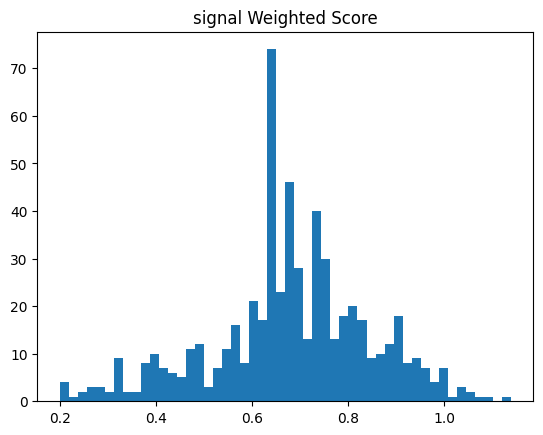

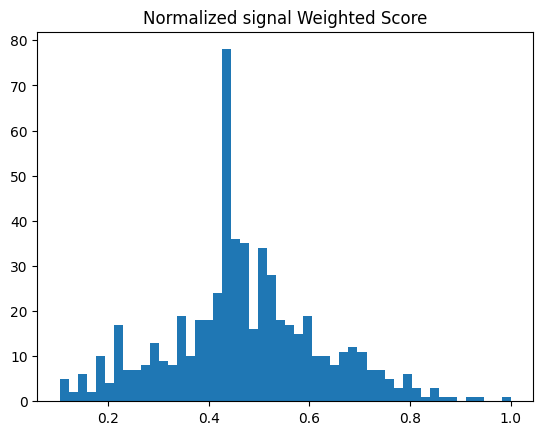

In [873]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(np.log1p(test_df["signal_weighted_score"]), bins=50)
plt.title("signal Weighted Score")
plt.show()

plt.hist(test_df["signal_normalized_weighted_score"], bins=50)
plt.title("Normalized signal Weighted Score")
plt.show()

In [861]:
print("Mean entropy:", test_df["wavelet_energy_entropy"].mean())
print("Max entropy:", test_df["wavelet_energy_entropy"].max())

Mean entropy: 3870223.4197646827
Max entropy: 4806387.492353101


In [876]:
original_df = pd.read_csv("/Users/zleblanc/Informing-The-Third-World/periodical_augmentation/periodical-issue-segmentation/scripts/wavelet_scripts/test_raw_original_signal_metrics.csv")
original_df.to_dict()

{'signal_type': {0: 'raw'},
 'dynamic_cutoff': {0: 195.80000000000007},
 'dominant_frequency': {0: 0.0508474576271186},
 'amplitude_max': {0: 2993.835955477632},
 'num_fft_peaks': {0: 3},
 'positive_frequencies': {0: '[0.0, 0.01694915254237288, 0.03389830508474576, 0.05084745762711865, 0.06779661016949153, 0.0847457627118644, 0.1016949152542373, 0.11864406779661017, 0.13559322033898305, 0.15254237288135594, 0.1694915254237288, 0.1864406779661017, 0.2033898305084746, 0.22033898305084745, 0.23728813559322035, 0.2542372881355932, 0.2711864406779661, 0.288135593220339, 0.3050847457627119, 0.3220338983050847, 0.3389830508474576, 0.3559322033898305, 0.3728813559322034, 0.3898305084745763, 0.4067796610169492, 0.423728813559322, 0.4406779661016949, 0.4576271186440678, 0.4745762711864407]'},
 'positive_amplitudes': {0: '[30072.0, 4461.956743542109, 1631.5164666187516, 2578.948005685255, 2993.835955477632, 2643.0758994466623, 893.3985151674731, 998.5535729581832, 983.2843232961881, 694.853493007

In [874]:
test_df[0:1].to_dict()

{'wavelet': {0: 'sym12'},
 'wavelet_level': {0: 1},
 'wavelet_mode': {0: 'antisymmetric'},
 'wavelet_mse': {0: 4.686695822817198e-23},
 'wavelet_psnr': {0: 280.7344577775807},
 'wavelet_energy_entropy': {0: 4339360.505996753},
 'wavelet_sparsity': {0: 0.5487804878048781},
 'wavelet_adaptive_threshold': {0: 306.6030503291225},
 'signal_length': {0: 59},
 'signal_type': {0: 'raw'},
 'emd_value': {0: 5.231160137832455e-12},
 'kl_divergence': {0: -8.614187141381079e-11},
 'wavelet_entropy': {0: 5.235707141169984},
 'avg_variance_across_levels': {0: 211980.60107933992},
 'variance_ratio_across_levels': {0: 0.9583302390940014},
 'smoothness': {0: 1.0369060324827289e-05},
 'correlation': {0: 0.9999999999999996},
 'dynamic_cutoff': {0: 195.79999999999117},
 'dominant_frequency': {0: 0.0508474576271186},
 'amplitude_max': {0: 2993.835955477704},
 'num_fft_peaks': {0: 3},
 'positive_frequencies': {0: '[0.0, 0.01694915254237288, 0.03389830508474576, 0.05084745762711865, 0.06779661016949153, 0.084

In [868]:
test_df[["wavelet", "wavelet_level", "wavelet_mode", "stability_rank", "final_family_stability_rank", "family_informed_rank","reconstruction_normalized_weighted_rank", "signal_normalized_weighted_rank", "final_combined_weighted_rank" , "final_combined_summed_rank", "final_combined_dynamic_weighted_rank", "final_combined_dynamic_summed_rank", "final_combined_final_dynamic_rank"]].sort_values(by='stability_rank').head(50)

,wavelet,wavelet_level,wavelet_mode,stability_rank,final_family_stability_rank,family_informed_rank,reconstruction_normalized_weighted_rank,signal_normalized_weighted_rank,final_combined_weighted_rank,final_combined_summed_rank,final_combined_dynamic_weighted_rank,final_combined_dynamic_summed_rank,final_combined_final_dynamic_rank
460,db15,1,antisymmetric,1,2,1.25,538,1,362,350,454,443,461
342,db14,1,antisymmetric,2,2,2.00,452,2,291,320,352,328,343
371,coif5,1,antisymmetric,3,1,2.50,560,3,391,388,374,387,372
201,db15,1,antireflect,4,2,3.50,225,4,35,232,203,74,202
205,bior3.9,1,antisymmetric,5,3,4.50,303,5,71,63,208,85,206
207,rbio3.9,1,antireflect,6,4,5.50,321,6,91,86,212,90,208
335,db14,1,antireflect,7,2,5.75,442,8,289,341,335,330,336
208,coif5,1,antireflect,8,1,6.25,180,7,22,171,213,97,209
211,db13,1,antisymmetric,9,2,7.25,194,9,28,189,215,106,212
378,coif4,1,antisymmetric,10,1,7.75,564,10,396,385,378,440,379


In [852]:
test_df[[  "reconstruction_normalized_weighted_rank","reconstruction_summed_score", "reconstruction_normalized_summed_score", "reconstruction_normalized_summed_rank", "signal_weighted_score", "signal_normalized_weighted_score", "signal_normalized_weighted_rank", "signal_summed_score", "signal_normalized_summed_score", "signal_normalized_summed_rank", ]].corr()

,reconstruction_normalized_weighted_rank,reconstruction_summed_score,reconstruction_normalized_summed_score,reconstruction_normalized_summed_rank,signal_weighted_score,signal_normalized_weighted_score,signal_normalized_weighted_rank,signal_summed_score,signal_normalized_summed_score,signal_normalized_summed_rank
reconstruction_normalized_weighted_rank,1.000000,-0.737118,-0.737118,0.878455,0.502844,0.502844,-0.487010,0.415494,0.415494,-0.425026
reconstruction_summed_score,-0.737118,1.000000,1.000000,-0.826177,-0.427492,-0.427492,0.402161,-0.349216,-0.349216,0.353003
reconstruction_normalized_summed_score,-0.737118,1.000000,1.000000,-0.826177,-0.427492,-0.427492,0.402161,-0.349216,-0.349216,0.353003
reconstruction_normalized_summed_rank,0.878455,-0.826177,-0.826177,1.000000,0.406731,0.406731,-0.384959,0.347234,0.347234,-0.340865
signal_weighted_score,0.502844,-0.427492,-0.427492,0.406731,1.000000,1.000000,-0.963258,0.987097,0.987097,-0.954269
signal_normalized_weighted_score,0.502844,-0.427492,-0.427492,0.406731,1.000000,1.000000,-0.963258,0.987097,0.987097,-0.954269
signal_normalized_weighted_rank,-0.487010,0.402161,0.402161,-0.384959,-0.963258,-0.963258,1.000000,-0.948237,-0.948237,0.988640
signal_summed_score,0.415494,-0.349216,-0.349216,0.347234,0.987097,0.987097,-0.948237,1.000000,1.000000,-0.956558
signal_normalized_summed_score,0.415494,-0.349216,-0.349216,0.347234,0.987097,0.987097,-0.948237,1.000000,1.000000,-0.956558
signal_normalized_summed_rank,-0.425026,0.353003,0.353003,-0.340865,-0.954269,-0.954269,0.988640,-0.956558,-0.956558,1.000000


In [773]:
test_df[["wavelet", "wavelet_family", "reconstruction_weighted_score",  "reconstruction_normalized_weighted_score", "reconstruction_normalized_weighted_rank","reconstruction_summed_score", "reconstruction_normalized_summed_score", "reconstruction_normalized_summed_rank", "signal_weighted_score", "signal_normalized_weighted_score", "signal_normalized_weighted_rank", "signal_summed_score", "signal_normalized_summed_score", "signal_normalized_summed_rank", ]].sort_values(by='reconstruction_normalized_weighted_rank', ascending=True)

,wavelet,wavelet_family,reconstruction_weighted_score,reconstruction_normalized_weighted_score,reconstruction_normalized_weighted_rank,reconstruction_summed_score,reconstruction_normalized_summed_score,reconstruction_normalized_summed_rank,signal_weighted_score,signal_normalized_weighted_score,signal_normalized_weighted_rank,signal_summed_score,signal_normalized_summed_score,signal_normalized_summed_rank
63,sym3,sym,5.399665,1.000000,1,12.250061,0.886561,3,0.924488,0.377531,528,2.481228,0.477165,427
25,sym3,sym,5.374792,0.995394,2,13.817510,1.000000,1,0.992673,0.405376,504,2.652833,0.510166,326
170,sym3,sym,5.228245,0.968254,3,13.344289,0.965752,2,0.890818,0.363781,534,2.374029,0.456549,465
333,sym3,sym,4.906417,0.908652,4,11.114122,0.804351,5,0.768890,0.313990,564,2.084251,0.400822,534
534,sym3,sym,4.854799,0.899093,5,11.092244,0.802767,6,0.713032,0.291179,577,1.934084,0.371943,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,db14,db,0.980801,0.181641,581,3.132383,0.226697,573,1.398022,0.570907,230,2.957857,0.568825,217
115,db10,db,0.980775,0.181636,582,3.132354,0.226695,583,1.594042,0.650955,113,3.238199,0.622738,133
209,db14,db,0.980758,0.181633,583,3.132308,0.226691,584,1.393694,0.569140,232,2.939530,0.565300,225
61,db10,db,0.980751,0.181632,584,3.132360,0.226695,574,1.805737,0.737405,51,3.771279,0.725254,52


In [785]:
cols = test_df.columns.tolist()
score_cols = [col for col in cols if ("score" in col) and ("zscore" not in col)]
final_score_cols = []

for metric_type in ["reconstruction", "signal", "family", "stability"]:
	for col in score_cols:
		if (metric_type in col) and ("correlation" not in col):
			final_score_cols.append(col)
rank_cols = [col for col in cols if "rank" in col]
final_rank_cols = []

for metric_type in ["reconstruction", "signal", "family", "stability"]:
	for col in rank_cols:
		if (metric_type in col) and ("correlation" not in col):
			final_rank_cols.append(col)

final_rank_cols.remove("stability_rank")
final_score_cols, final_rank_cols

(['reconstruction_weighted_score',
  'reconstruction_normalized_weighted_score',
  'reconstruction_summed_score',
  'reconstruction_normalized_summed_score',
  'reconstruction_dynamically_weighted_score',
  'reconstruction_dynamically_weighted_summed_score',
  'reconstruction_normalized_dynamically_weighted_score',
  'reconstruction_normalized_dynamically_weighted_summed_score',
  'reconstruction_final_normalized_dynamic_score',
  'signal_weighted_score',
  'signal_normalized_weighted_score',
  'signal_summed_score',
  'signal_normalized_summed_score',
  'signal_dynamically_weighted_score',
  'signal_dynamically_weighted_summed_score',
  'signal_normalized_dynamically_weighted_score',
  'signal_normalized_dynamically_weighted_summed_score',
  'signal_final_normalized_dynamic_score',
  'final_family_stability_score',
  'stability_score_weighted',
  'final_family_stability_score'],
 ['reconstruction_normalized_weighted_rank',
  'reconstruction_normalized_summed_rank',
  'reconstruction_d

In [786]:
test_df[["stability_rank"] + final_rank_cols].corr()

,stability_rank,reconstruction_normalized_weighted_rank,reconstruction_normalized_summed_rank,reconstruction_dynamic_weighted_rank,reconstruction_dynamic_summed_rank,reconstruction_final_dynamic_rank,signal_normalized_weighted_rank,signal_normalized_summed_rank,signal_dynamic_weighted_rank,signal_dynamic_summed_rank,...,final_family_stability_rank,family_informed_rank,normalized_rank_stability,family_mean_stability_rank,family_median_stability_rank,family_rank_stability_std_dev,normalized_family_mean_stability_rank,normalized_family_median_stability_rank,normalized_family_rank_stability_std_dev,final_family_stability_rank
stability_rank,1.000000,-0.394804,-0.310322,-0.394650,-0.394699,-0.396831,0.954406,0.969947,0.954395,0.954441,...,0.282315,0.999996,-0.131878,0.290113,0.282685,0.120645,0.290113,0.282685,0.120645,0.282315
reconstruction_normalized_weighted_rank,-0.394804,1.000000,0.878455,0.999883,0.999786,0.996971,-0.487010,-0.425026,-0.486972,-0.487001,...,-0.581688,-0.396267,0.170697,-0.577204,-0.582526,-0.253134,-0.577204,-0.582526,-0.253134,-0.581688
reconstruction_normalized_summed_rank,-0.310322,0.878455,1.000000,0.878389,0.878318,0.865593,-0.384959,-0.340865,-0.384941,-0.384910,...,-0.452454,-0.311458,0.058762,-0.438990,-0.441504,-0.151298,-0.438990,-0.441504,-0.151298,-0.452454
reconstruction_dynamic_weighted_rank,-0.394650,0.999883,0.878389,1.000000,0.999691,0.997060,-0.486857,-0.424879,-0.486833,-0.486844,...,-0.581579,-0.396113,0.170746,-0.576581,-0.582307,-0.255207,-0.576581,-0.582307,-0.255207,-0.581579
reconstruction_dynamic_summed_rank,-0.394699,0.999786,0.878318,0.999691,1.000000,0.996817,-0.486887,-0.424990,-0.486895,-0.486918,...,-0.581265,-0.396161,0.170639,-0.576290,-0.582100,-0.255607,-0.576290,-0.582100,-0.255607,-0.581265
reconstruction_final_dynamic_rank,-0.396831,0.996971,0.865593,0.997060,0.996817,1.000000,-0.490886,-0.426650,-0.490861,-0.490851,...,-0.581515,-0.398292,0.172620,-0.576319,-0.581336,-0.252769,-0.576319,-0.581336,-0.252769,-0.581515
signal_normalized_weighted_rank,0.954406,-0.487010,-0.384959,-0.486857,-0.486887,-0.490886,1.000000,0.988640,0.999967,0.999945,...,0.333268,0.954601,-0.185111,0.345271,0.336368,0.142727,0.345271,0.336368,0.142727,0.333268
signal_normalized_summed_rank,0.969947,-0.425026,-0.340865,-0.424879,-0.424990,-0.426650,0.988640,1.000000,0.988667,0.988692,...,0.283719,0.969974,-0.150156,0.293136,0.283383,0.111766,0.293136,0.283383,0.111766,0.283719
signal_dynamic_weighted_rank,0.954395,-0.486972,-0.384941,-0.486833,-0.486895,-0.490861,0.999967,0.988667,1.000000,0.999928,...,0.333659,0.954591,-0.185082,0.345613,0.336618,0.142201,0.345613,0.336618,0.142201,0.333659
signal_dynamic_summed_rank,0.954441,-0.487001,-0.384910,-0.486844,-0.486918,-0.490851,0.999945,0.988692,0.999928,1.000000,...,0.333166,0.954635,-0.185100,0.344956,0.336249,0.144180,0.344956,0.336249,0.144180,0.333166


In [777]:
test_df[['wavelet', 'wavelet_family'] + final_score_cols + rank_cols].sort_values(by='reconstruction_normalized_weighted_rank', ascending=True)

,wavelet,wavelet_family,reconstruction_weighted_score,reconstruction_normalized_weighted_score,reconstruction_summed_score,reconstruction_normalized_summed_score,reconstruction_dynamically_weighted_score,reconstruction_dynamically_weighted_summed_score,reconstruction_normalized_dynamically_weighted_score,reconstruction_normalized_dynamically_weighted_summed_score,...,family_mean_weighted_avg_rank,family_rank_correlation_avg,normalized_family_mean_stability_rank,normalized_family_median_stability_rank,normalized_family_rank_stability_std_dev,normalized_family_mean_rank_variability,normalized_family_mean_weighted_avg_rank,normalized_family_rank_correlation_avg,final_family_stability_rank,family_informed_rank
63,sym3,sym,5.399665,1.000000,12.250061,0.886561,0.514254,0.514254,1.000000,1.000000,...,129.722245,NaN,1.000000,1.00000,1.000000,1.000000,0.778869,0.166667,6,49.50
25,sym3,sym,5.374792,0.995394,13.817510,1.000000,0.511885,0.511885,0.995394,0.995394,...,129.722245,NaN,1.000000,1.00000,1.000000,1.000000,0.778869,0.166667,6,21.00
170,sym3,sym,5.228245,0.968254,13.344289,0.965752,0.497928,0.497928,0.968254,0.968254,...,129.722245,NaN,1.000000,1.00000,1.000000,1.000000,0.778869,0.166667,6,129.75
333,sym3,sym,4.906417,0.908652,11.114122,0.804351,0.467278,0.467278,0.908652,0.908652,...,129.722245,NaN,1.000000,1.00000,1.000000,1.000000,0.778869,0.166667,6,252.00
534,sym3,sym,4.854799,0.899093,11.092244,0.802767,0.462362,0.462362,0.899093,0.899093,...,129.722245,NaN,1.000000,1.00000,1.000000,1.000000,0.778869,0.166667,6,402.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,db14,db,0.980801,0.181641,3.132383,0.226697,0.093410,0.093410,0.181641,0.181641,...,166.552132,NaN,0.653402,0.46646,0.833284,0.708418,1.000000,0.166667,2,157.25
115,db10,db,0.980775,0.181636,3.132354,0.226695,0.093407,0.093407,0.181636,0.181636,...,166.552132,NaN,0.653402,0.46646,0.833284,0.708418,1.000000,0.166667,2,87.50
209,db14,db,0.980758,0.181633,3.132308,0.226691,0.093406,0.093406,0.181633,0.181633,...,166.552132,NaN,0.653402,0.46646,0.833284,0.708418,1.000000,0.166667,2,158.00
61,db10,db,0.980751,0.181632,3.132360,0.226695,0.093405,0.093405,0.181632,0.181632,...,166.552132,NaN,0.653402,0.46646,0.833284,0.708418,1.000000,0.166667,2,47.00


## Older Code

In [74]:
combined_df = pd.concat([full_raw_corr, full_smoothed_corr])
melted_df = pd.melt(combined_df, id_vars=['metric', 'data_type', 'signal_type'], value_vars=['reconstruction_score_sum', 'wavelet_summed_norm_score', "reconstruction_score_weighted", 'final_score',  'summed_scores'])

In [75]:
melted_df[0:1]

,metric,data_type,signal_type,variable,value
0,summed_scores,full,raw,reconstruction_score_sum,0.998508


In [76]:
# Compute correlations of ranking systems with reconstruction score
corr_summed = melted_df[melted_df["variable"] == "reconstruction_score_sum"].groupby(["data_type", "signal_type"])["value"].corr(melted_df["value"])
corr_weighted = melted_df[melted_df["variable"] == "reconstruction_score_weighted"].groupby(["data_type", "signal_type"])["value"].corr(melted_df["value"])

# Check stability (Standard Deviation)
std_summed = melted_df[melted_df["variable"] == "reconstruction_score_sum"].groupby(["data_type", "signal_type"])["value"].std()
std_weighted = melted_df[melted_df["variable"] == "reconstruction_score_weighted"].groupby(["data_type", "signal_type"])["value"].std()

print("Correlation with Reconstruction Score:")
print("Summed:", corr_summed)
print("Weighted:", corr_weighted)

print("\nStability (Lower is better):")
print("Summed Std Dev:", std_summed)
print("Weighted Std Dev:", std_weighted)

Correlation with Reconstruction Score:
Summed: data_type  signal_type
full       raw            1.0
           smoothed       1.0
Name: value, dtype: float64
Weighted: data_type  signal_type
full       raw            1.0
           smoothed       1.0
Name: value, dtype: float64

Stability (Lower is better):
Summed Std Dev: data_type  signal_type
full       raw            0.461400
           smoothed       0.398616
Name: value, dtype: float64
Weighted Std Dev: data_type  signal_type
full       raw            0.338030
           smoothed       0.386786
Name: value, dtype: float64


In [77]:
from scipy.stats import spearmanr

# Compare ranking stability across conditions
df_pivot = melted_df.pivot(index=["metric", "variable"], columns=["data_type", "signal_type"], values="value")

# Compute pairwise Spearman rank correlation between conditions
rank_corr = df_pivot.rank(axis=1).corr(method="spearman")

print("Rank Stability (Spearman Correlation Matrix):")
print(rank_corr)

Rank Stability (Spearman Correlation Matrix):
data_type             full         
signal_type            raw smoothed
data_type signal_type              
full      raw          1.0     -1.0
          smoothed    -1.0      1.0


In [78]:
melted_df.pivot(index=["metric", "variable"], columns=["data_type", "signal_type"], values="value").to_clipboard()

In [79]:
melted_df['combined_type'] = melted_df['data_type'] + " / " + melted_df['signal_type']
melted_df['combined_metric'] = melted_df['metric'] + " / " + melted_df['variable']

In [80]:
melted_df.variable.unique()

array(['reconstruction_score_sum', 'wavelet_summed_norm_score',
       'reconstruction_score_weighted', 'final_score', 'summed_scores'],
      dtype=object)

In [81]:
import altair as alt
import warnings
warnings.filterwarnings("ignore")

selection = alt.selection_multi(fields=['combined_metric'], bind='legend')
alt.Chart(melted_df).mark_line(point=True).encode(
	x=alt.X('combined_type:N', axis=alt.Axis(title='Data Type and Signal Type'), sort=['subset_raw', 'full_raw', 'subset_smoothed', 'full_smoothed']),
	# x=alt.X('variable:N', axis=alt.Axis(title='Score Type'), sort=['reconstruction_score_sum', 'wavelet_summed_norm_score',
    #    'summed_scores']),
	y='value:Q',
	color=alt.Color('combined_metric:N', legend=alt.Legend(title='Metric and Variable', symbolLimit=0, columns=3)),
	opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
	shape='variable:N',
	tooltip=['combined_metric', 'value', 'combined_type']
).add_params(selection).properties(width=800, height=800)

alt.Chart(...)

In [82]:
melted_df.variable.unique()

array(['reconstruction_score_sum', 'wavelet_summed_norm_score',
       'reconstruction_score_weighted', 'final_score', 'summed_scores'],
      dtype=object)

In [83]:


selection = alt.selection_multi(fields=['metric'], bind='legend')
alt.Chart(melted_df[(melted_df.value < 1) & (melted_df.variable.isin(['reconstruction_score_sum', 'wavelet_summed_norm_score',  'reconstruction_score_weighted', 'final_score']))]).mark_line(point=True).encode(
	x=alt.X('variable:N', axis=alt.Axis(title='Data Type and Signal Type'), sort=['reconstruction_score_sum', 'wavelet_summed_norm_score',
       'reconstruction_score_weighted', 'final_score']),
	# x=alt.X('variable:N', axis=alt.Axis(title='Score Type'), sort=['reconstruction_score_sum', 'wavelet_summed_norm_score',
    #    'summed_scores']),
	y='value:Q',
	color=alt.Color('metric:N', legend=alt.Legend(title='Metric and Variable', symbolLimit=0, columns=3)),
	opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
	shape='variable:N',
	row='data_type:N',
	column='signal_type:N',
	tooltip=['metric', 'variable', 'value', 'data_type', 'signal_type']
).add_params(selection).properties(width=400, height=200)

alt.Chart(...)

In [84]:
def calculate_rank_stability_from_melted(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate stability metric for rankings from a melted dataframe setup.

    Parameters:
    -----------
    df : pd.DataFrame
        Melted dataframe with columns ['metric', 'data_type', 'signal_type', 'variable', 'value'].

    Returns:
    --------
    pd.DataFrame
        DataFrame with rank stability metrics for each metric and variable.
    """
    # Step 1: Pivot the melted dataframe
    pivoted_df = df.pivot(
        index=["metric", "variable"],  # Metrics and variables as indices
        columns="combined_type",  # Create columns based on the data_type/signal_type combo
        values="value"
    ).reset_index()

    # Step 2: Calculate absolute differences and rank stability across columns
    columns_to_compare = pivoted_df.columns.difference(["metric", "variable"])  # Dynamic column selection

    # Compute absolute differences between columns
    for col_a in columns_to_compare:
        for col_b in columns_to_compare:
            if col_a != col_b:
                diff_col_name = f"{col_a}_vs_{col_b}_abs_diff"
                pivoted_df[diff_col_name] = (pivoted_df[col_a] - pivoted_df[col_b]).abs()

    # Calculate standard deviation of values across columns
    pivoted_df['rank_std_dev'] = pivoted_df[columns_to_compare].std(axis=1)

    # Normalize the standard deviation by the maximum possible rank (assuming ranks are between 0 and 1)
    pivoted_df['rank_stability'] = 1 - pivoted_df['rank_std_dev']  # Stability as inverse of variability

    return pivoted_df

pivoted_df = calculate_rank_stability_from_melted(melted_df)

In [85]:
pivoted_df[0:1].to_dict()

{'metric': {0: 'amplitude_max_diff_normalized'},
 'variable': {0: 'final_score'},
 'full / raw': {0: 0.14665122504388498},
 'full / smoothed': {0: 0.08913634117191484},
 'full / raw_vs_full / smoothed_abs_diff': {0: 0.05751488387197014},
 'full / smoothed_vs_full / raw_abs_diff': {0: 0.05751488387197014},
 'rank_std_dev': {0: 0.04066916440502688},
 'rank_stability': {0: 0.9593308355949731}}

In [86]:
pivoted_df

combined_type,metric,variable,full / raw,full / smoothed,full / raw_vs_full / smoothed_abs_diff,full / smoothed_vs_full / raw_abs_diff,rank_std_dev,rank_stability
0,amplitude_max_diff_normalized,final_score,0.146651,0.089136,0.057515,0.057515,0.040669,0.959331
1,amplitude_max_diff_normalized,reconstruction_score_sum,0.569809,0.339185,0.230624,0.230624,0.163076,0.836924
2,amplitude_max_diff_normalized,reconstruction_score_weighted,-0.123590,-0.129996,0.006406,0.006406,0.004529,0.995471
3,amplitude_max_diff_normalized,summed_scores,0.584137,0.370541,0.213596,0.213596,0.151035,0.848965
4,amplitude_max_diff_normalized,wavelet_summed_norm_score,0.534026,0.539957,0.005931,0.005931,0.004194,0.995806
...,...,...,...,...,...,...,...,...
180,wavelet_summed_norm_score,final_score,0.459282,0.286711,0.172571,0.172571,0.122026,0.877974
181,wavelet_summed_norm_score,reconstruction_score_sum,0.520711,0.132582,0.388129,0.388129,0.274449,0.725551
182,wavelet_summed_norm_score,reconstruction_score_weighted,-0.012912,-0.145981,0.133070,0.133070,0.094094,0.905906
183,wavelet_summed_norm_score,summed_scores,0.566550,0.195930,0.370620,0.370620,0.262068,0.737932


In [87]:
melted_df

,metric,data_type,signal_type,variable,value,combined_type,combined_metric
0,summed_scores,full,raw,reconstruction_score_sum,0.998508,full / raw,summed_scores / reconstruction_score_sum
1,reconstruction_score_sum,full,raw,reconstruction_score_sum,1.000000,full / raw,reconstruction_score_sum / reconstruction_scor...
2,relative_right_bases_global_alignment_score_no...,full,raw,reconstruction_score_sum,0.804091,full / raw,relative_right_bases_global_alignment_score_no...
3,relative_right_bases_matcher_alignment_score_n...,full,raw,reconstruction_score_sum,0.804091,full / raw,relative_right_bases_matcher_alignment_score_n...
4,spectral_centroid_diff_normalized,full,raw,reconstruction_score_sum,0.676341,full / raw,spectral_centroid_diff_normalized / reconstruc...
...,...,...,...,...,...,...,...
355,positive_amplitudes_euclidean_normalized,full,smoothed,summed_scores,-0.378013,full / smoothed,positive_amplitudes_euclidean_normalized / sum...
356,positive_amplitudes_dtw_normalized,full,smoothed,summed_scores,-0.383116,full / smoothed,positive_amplitudes_dtw_normalized / summed_sc...
357,positive_amplitudes_wasserstein_normalized,full,smoothed,summed_scores,-0.383116,full / smoothed,positive_amplitudes_wasserstein_normalized / s...
358,prominence_min_diff_normalized,full,smoothed,summed_scores,-0.420702,full / smoothed,prominence_min_diff_normalized / summed_scores


In [88]:
pivoted_df.columns

Index(['metric', 'variable', 'full / raw', 'full / smoothed',
       'full / raw_vs_full / smoothed_abs_diff',
       'full / smoothed_vs_full / raw_abs_diff', 'rank_std_dev',
       'rank_stability'],
      dtype='object', name='combined_type')

In [89]:


alt.Chart(pivoted_df).mark_bar().encode(
	y=alt.Y('metric:N', title='Metric'),
    x=alt.X('rank_stability:Q', title='Rank Stability', sort='-y', ),
    color=alt.Color('variable:N', legend=alt.Legend(title="Variable")),
    tooltip=['metric', 'variable', 'rank_stability']
).properties(width=800, height=400, title="Rank Stability Across Metrics and Variables")

alt.Chart(...)

In [90]:


alt.Chart(pivoted_df).mark_line(point=True).encode(
	x=alt.X('variable:N', axis=alt.Axis(title='Variable'), sort=['reconstruction_score_sum', 'wavelet_summed_norm_score',
	   'reconstruction_score_weighted', 'final_score']),
    y=alt.Y('rank_stability:Q', title='Rank Stability', sort='-y', ),
    color=alt.Color('metric:N', legend=alt.Legend(title="Metric", symbolLimit=0, columns=3)),
    tooltip=['metric', 'variable', 'rank_stability']
).properties(width=800, height=400, title="Rank Stability Across Metrics and Variables")

alt.Chart(...)